### Dal Zotto Luca - 1236343

# Prediction with Timestamp Encoding.
#### Project for the Process Mining Course – University of Padua

In this project we aim at enriching classical control-flow encodings with information derived 
from timestamps. Having features capturing more than one aspect related to the timestamp 
of the execution of an event could improve the accuracy of the prediction and could be useful 
to make it clear what time-related aspect(s) influence(s) most the predictions.

# Point Colaboratory to Google Drive

Since I used a python notebook, the output of each cell is saved and can be read by the professors. However, if they desire to re-run some parts of the code, an easy way is to save the folder "PM Project Dal Zotto" in your Drive. Then, point Colaboratory to that folder. To do so, run the following cell, click on the link, access with the Google account where the folder "PM Project Dal Zotto" is saved, copy the authorization code and paste it in the cell. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive



Then modify this second cell according to your folder path, similarly to what I have done.

In [ ]:
datapath = '/content/gdrive/My Drive/^DATA SCIENCE/^Process Mining/PM Project Dal Zotto/' # Luca

# datapath = '/content/gdrive/My Drive/MODIFY_THIS_PART_ACCORDING_TO_YOUR_PATH/PM Project Dal Zotto/' # PROFESSOR

# Import & intallation of packages

Install the library pm4py

In [ ]:
%%capture 
!pip install pm4py

Import some libraries

In [ ]:
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import math

import warnings

# Load dataset

Firsts step: load the dataset

In [ ]:
train = xes_importer.apply(datapath + 'BPIChallenge2011_training_0-80.xes')

In [ ]:
test = xes_importer.apply(datapath + 'BPIChallenge2011_testing_80-100.xes')

Check the first trace and the first event, to see if the import worked correctly

In [ ]:
case = next(iter(train))
case

{'attributes': {'Start date': datetime.datetime(2005, 1, 3, 0, 14, 24, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': '00000000', 'Diagnosis code': 'M13', 'End date': datetime.datetime(2005, 1, 29, 23, 45, 36, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'Specialism code': 'SC61', 'Treatment code': 'TC103', 'Diagnosis': 'maligniteit cervix', 'Diagnosis Treatment Combination ID': 'DTC376907', 'label': 'false', 'Age': 33}, 'events': [{'Activity code': 'AC410100', 'concept:name': 'First outpatient consultation', 'Specialism code': 'SC61', 'Producer code': 'SRTH', 'lifecycle:transition': 'complete', 'Section': 'Section 5', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'group': 'Radiotherapy'}, '..', {'Activity code': 'AC379999', 'concept:name': 'order rate', 'Specialism code': 'SC86', 'Producer code': 'CRLA', 'lifecycle:transition': 'complete', 'Sect

In [ ]:
event = next(iter(case))
event

{'Activity code': 'AC410100', 'concept:name': 'First outpatient consultation', 'Specialism code': 'SC61', 'Producer code': 'SRTH', 'lifecycle:transition': 'complete', 'Section': 'Section 5', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'group': 'Radiotherapy'}

# Timestamp Encoding
Write the following Python functions:

### 1) encode_trace_simple_index (trace):

a Python function that takes as input an 
execution trace of a certain length (a prefix of an execution trace) and returns as 
output a vector encoding the trace using the simple index encoding. In detail, in the 
simple index encoding a (prefix) trace of length pl is encoded as a vector of length pl, 
where the p-th item corresponds to the name of the p-th event (Please remember that you need to convert the event name (and all the other non-numerical values) into a 
numeric format). 

In [ ]:
def encode_trace_simple_index(trace):
    
    events = []
    
    for event_index, event in enumerate(trace):
        # Compute prefix iterating over the trace, but stop if the length is higher than 20
        if event_index < 20:
            events.append(event['concept:name']) 
    
    # Implement padding by adding an empty string if the trace length is smaller than 20
    while len(events) < 20:
        events.append('')
                
    return events

In [ ]:
# Example
encode_trace_simple_index(case)

['First outpatient consultation',
 'administrative fee - the first pol',
 'verlosk.-gynaec. short-out card cost',
 'ultrasound - internal genitals',
 'First outpatient consultation',
 'administrative fee - the first pol',
 'simulator - use before megavol',
 'treatment time - Unit t3 - megavolt',
 'teletherapy - megavolt photons bestrali',
 'assumption laboratory',
 'assumption laboratory',
 'urea',
 'hemoglobin photoelectric',
 'creatinine',
 'sodium flame photometry',
 'potassium potentiometrically',
 'leukocyte count electronic',
 'platelet count - Electronic',
 'order rate',
 'demurrage - all spec.beh.kinderg.-Reval.']

### 2) encode_timestamp (timestamp): 

a Python function that takes as input the timestamp 
of an event and returns as output a vector containing:
- the timestamp itself in epoch timestamp (e.g., 1104715500000)
- the timestamp itself in human-readable format (e.g., 2005-01-03 
02:25:00+01:00)
- the day of the year (e.g., 3)
- the day of the week (e.g., 1)
- the month of the year (e.g., 1)
- the hour of the day in local time (e.g., 2)
- the minutes of the hour in local time (e.g., 25)
- the concatenation of hour and minutes of the day in local time (e.g., 225).

In [ ]:
# Example
timestamp = event['time:timestamp']
timestamp

datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600)))

In [ ]:
date = pd.to_datetime(timestamp)
date

Timestamp('2005-01-03 00:00:00+0100', tz='UTC+01:00')

In [ ]:
def encode_timestamp(timestamp):

    # Convert the timestamp in a pandas format, since it provides easier ways to access the desired information
    timestamp_pd = pd.to_datetime(timestamp)

    time_vector = [timestamp_pd.timestamp(),
                   str(timestamp_pd),
                   timestamp_pd.dayofyear,
                   timestamp_pd.dayofweek + 1,  # + 1 because it is zero-based
                   timestamp_pd.month,
                   timestamp_pd.hour,
                   timestamp_pd.minute,
                   str(timestamp_pd.hour) + str(timestamp_pd.minute)
                   ]

    return time_vector

In [ ]:
# Example
encode_timestamp(timestamp)

[1104706800.0, '2005-01-03 00:00:00+01:00', 3, 1, 1, 0, 0, '00']

### 3) encode_event_simple_index_with_timestamp (event): 

a Python function that takes as 
input an event and returns as output a vector encoding the event using the simple 
index with timestamp encoding. In detail, in the simple index with timestamp encoding 
the name of the event is concatenated to the timestamp vector encoding returned by 
the encode_timestamp function.

In [ ]:
def encode_event_simple_index_with_timestamp(event):
    
    # access the name and timestamp attributes
    name = event['concept:name']  
    timestamp = event['time:timestamp'] 
    
    # call the previously defined function
    time_vector = encode_timestamp(timestamp)

    # concatenate name and timestamp vector
    event_with_timestamp = [name] + time_vector

    return event_with_timestamp

In [ ]:
# example
encode_event_simple_index_with_timestamp(event)

['First outpatient consultation',
 1104706800.0,
 '2005-01-03 00:00:00+01:00',
 3,
 1,
 1,
 0,
 0,
 '00']

### 4) encode_trace_simple_index_with_timestamp (trace): 

a Python function that takes as 
input an execution trace of a certain length (a prefix of an execution trace) and returns 
as output a vector encoding the trace using the simple index with timestamp encoding. 
In detail, in the simple index with timestamp encoding the trace is encoded by 
concatenating the encoding returned by the 
encode_event_simple_index_with_timestamp function of each event at position p up 
to the prefix length pl 

In [ ]:
def encode_trace_simple_index_with_timestamp(trace):

    events = []

    for event_index, event in enumerate(trace):
        # Compute prefix iterating over the trace, but stop if the length is higher than 20
        if event_index < 20:
            # call the previous function
            events += encode_event_simple_index_with_timestamp(event)

    # Implement padding by adding an enpty string if the trace length is smaller than 20 
    # Att: event_index is zero-based
    while event_index < 19:
        events += ['', 0.0, '0000-00-00 00:00:00+01:00', 0, 0, 0, 0, 0, '00']
        event_index += 1

    return events

In [ ]:
encode_trace_simple_index_with_timestamp(case)

['First outpatient consultation',
 1104706800.0,
 '2005-01-03 00:00:00+01:00',
 3,
 1,
 1,
 0,
 0,
 '00',
 'administrative fee - the first pol',
 1104706800.0,
 '2005-01-03 00:00:00+01:00',
 3,
 1,
 1,
 0,
 0,
 '00',
 'verlosk.-gynaec. short-out card cost',
 1104879600.0,
 '2005-01-05 00:00:00+01:00',
 5,
 3,
 1,
 0,
 0,
 '00',
 'ultrasound - internal genitals',
 1104879600.0,
 '2005-01-05 00:00:00+01:00',
 5,
 3,
 1,
 0,
 0,
 '00',
 'First outpatient consultation',
 1104879600.0,
 '2005-01-05 00:00:00+01:00',
 5,
 3,
 1,
 0,
 0,
 '00',
 'administrative fee - the first pol',
 1104879600.0,
 '2005-01-05 00:00:00+01:00',
 5,
 3,
 1,
 0,
 0,
 '00',
 'simulator - use before megavol',
 1106521200.0,
 '2005-01-24 00:00:00+01:00',
 24,
 1,
 1,
 0,
 0,
 '00',
 'treatment time - Unit t3 - megavolt',
 1107126000.0,
 '2005-01-31 00:00:00+01:00',
 31,
 1,
 1,
 0,
 0,
 '00',
 'teletherapy - megavolt photons bestrali',
 1107126000.0,
 '2005-01-31 00:00:00+01:00',
 31,
 1,
 1,
 0,
 0,
 '00',
 'assump

# Data Exploration

First let's see the description of the dataset provided by the organizers of the challenge

"We have prepared a real-life log, taken from a Dutch Academic Hospital. This log contains some 150.000 events in over 1100 cases. Apart from some anonymization, the log contains all data as it came from the Hospital's systems. Each case is a patient of a Gynaecology department. The log contains information about when certain activities took place, which group performed the activity and so on. Many attributes have been recorded that are relevant to the process. Some attributes are repeated more than once for a patient, indicating that this patient went through different (maybe overlapping) phases, where a phase consists of the combination Diagnosis & Treatment."

Source: https://www.win.tue.nl/bpi/doku.php?id=2011:challenge

To get more insights about the dataset, and also to exploit the functionalities that we saw in class of the pm4py library, I will explore more in details the trace level attributes and also event level attributes. In what follows, I will check their distributions to understand which ones could be used for prediction purposes.

### Trace level attributes

In [ ]:
case.attributes

{'Age': 33,
 'Diagnosis': 'maligniteit cervix',
 'Diagnosis Treatment Combination ID': 'DTC376907',
 'Diagnosis code': 'M13',
 'End date': datetime.datetime(2005, 1, 29, 23, 45, 36, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Specialism code': 'SC61',
 'Start date': datetime.datetime(2005, 1, 3, 0, 14, 24, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))),
 'Treatment code': 'TC103',
 'concept:name': '00000000',
 'label': 'false'}

In [ ]:
case_attributes = set()

for case_index, case in enumerate(train):
    case_attributes |= set(case.attributes.keys())

case_attributes

{'Age',
 'Diagnosis',
 'Diagnosis Treatment Combination ID',
 'Diagnosis code',
 'End date',
 'Specialism code',
 'Start date',
 'Treatment code',
 'concept:name',
 'label'}

In [ ]:
trace_attributes_data = []

for case_index, case in enumerate(train):
    t = [case.attributes['concept:name'],
        case.attributes['Age'],
        case.attributes['Diagnosis'],
        case.attributes['Diagnosis code'],
        case.attributes['Diagnosis Treatment Combination ID'],
        case.attributes['Specialism code'],
        case.attributes['Treatment code'],
        # case.attributes['Start date'],
        # case.attributes['End date'],
        # case.attributes['label'],
        ]
    
    columns = ['name', 'age', 'diagnosis','diagnosis_code', 'diagnosis_treatment_combination_ID', 'specialism_code', 'treatment_code']

    t += encode_timestamp(case.attributes['Start date'])   
    columns += ['epoch_s', 'readable_format_s', 'day_of_year_s', 'day_of_week_s', 'month_s', 'hour_s', 'minutes_s', 'hour_minutes_s']
        
    t += encode_timestamp(case.attributes['End date'])   
    columns += ['epoch_e', 'readable_format_e', 'day_of_year_e', 'day_of_week_e', 'month_e', 'hour_e', 'minutes_e', 'hour_minutes_e']
    
    t.append(case.attributes["label"])
    columns.append('label')
    
    trace_attributes_data.append(t)

trace_attributes_df = pd.DataFrame(columns=columns, data=trace_attributes_data)
trace_attributes_df

,name,age,diagnosis,diagnosis_code,diagnosis_treatment_combination_ID,specialism_code,treatment_code,epoch_s,readable_format_s,day_of_year_s,day_of_week_s,month_s,hour_s,minutes_s,hour_minutes_s,epoch_e,readable_format_e,day_of_year_e,day_of_week_e,month_e,hour_e,minutes_e,hour_minutes_e,label
0,00000000,33,maligniteit cervix,M13,DTC376907,SC61,TC103,1.104708e+09,2005-01-03 00:14:24+01:00,3,1,1,0,14,014,1.107039e+09,2005-01-29 23:45:36+01:00,29,6,1,23,45,2345,false
1,00000001,39,maligniteit cervix,DC822,DTC153637,SC7,TC3101,1.106263e+09,2005-01-21 00:14:24+01:00,21,5,1,0,14,014,1.137797e+09,2006-01-20 23:45:36+01:00,20,5,1,23,45,2345,false
2,00000002,52,maligniteit cervix,DC822,DTC395310,SC7,TC3201,1.138404e+09,2006-01-28 00:14:24+01:00,28,6,1,0,14,014,1.169938e+09,2007-01-27 23:45:36+01:00,27,6,1,23,45,2345,true
3,00000003,56,maligniteit ovarium,DC821,DTC262090,SC7,TC9101,1.138576e+09,2006-01-30 00:14:24+01:00,30,1,1,0,14,014,1.170111e+09,2007-01-29 23:45:36+01:00,29,1,1,23,45,2345,false
4,00000004,31,maligniteit ovarium | tuba,M16,DTC151957,SC7,TC803,1.136244e+09,2006-01-03 00:14:24+01:00,3,2,1,0,14,014,1.199314e+09,2008-01-02 23:45:36+01:00,2,3,1,23,45,2345,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,00000907,37,"Plaveiselcelca, cervix st Ia1",M13,DTC667327,SC7,TC503,1.169162e+09,2007-01-19 00:14:24+01:00,19,5,1,0,14,014,1.200696e+09,2008-01-18 23:45:36+01:00,18,5,1,23,45,2345,false
908,00000908,40,maligniteit cervix,DC822,DTC701763,SC61,TC803,1.168471e+09,2007-01-11 00:14:24+01:00,11,4,1,0,14,014,1.170284e+09,2007-01-31 23:45:36+01:00,31,3,1,23,45,2345,false
909,00000909,72,Clearcel ca: corpus uteri st Ib,M14,DTC787818,SC61,TC101,1.168471e+09,2007-01-11 00:14:24+01:00,11,4,1,0,14,014,1.168469e+09,2007-01-10 23:45:36+01:00,10,3,1,23,45,2345,true
910,00000910,72,maligniteit cervix,M13,DTC689148,SC61,TC1101,1.168903e+09,2007-01-16 00:14:24+01:00,16,2,1,0,14,014,1.169592e+09,2007-01-23 23:45:36+01:00,23,2,1,23,45,2345,true


Check if there are missing values

In [ ]:
# Check how missing values are distributed across each variable (i.e., column)
print(f'Total number of rows: {trace_attributes_df.shape[0]}')
print()
print('MISSING VALUES PER VARIABLE:\n')
trace_attributes_df.apply(lambda x: sum(x.isnull())) # apply applies the function column-wise

Total number of rows: 912

MISSING VALUES PER VARIABLE:



name                                  0
age                                   0
diagnosis                             0
diagnosis_code                        0
diagnosis_treatment_combination_ID    0
specialism_code                       0
treatment_code                        0
epoch_s                               0
readable_format_s                     0
day_of_year_s                         0
day_of_week_s                         0
month_s                               0
hour_s                                0
minutes_s                             0
hour_minutes_s                        0
epoch_e                               0
readable_format_e                     0
day_of_year_e                         0
day_of_week_e                         0
month_e                               0
hour_e                                0
minutes_e                             0
hour_minutes_e                        0
label                                 0
dtype: int64

In [ ]:
# Auxiliary function to plot the distribution of some attributes

def plot_most_freq(variable, k):

    '''plot the frequency of the k most frequent values of a variable'''

    vc = trace_attributes_df[variable].value_counts() # count values 

    if k == trace_attributes_df[variable].nunique():
        v = vc.values
        i = vc.index
    
    else: 
        v = vc[:k].values
        i = vc[:k].index

    fig, ax = plt.subplots(figsize=(20,7))
    ax.bar(range(k), v)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Most frequent {variable}')
    ax.set_xticks(np.arange(k))
    ax.set_xticklabels(i)
    plt.show()

In [ ]:
trace_attributes_df.describe(include='all')

,name,age,diagnosis,diagnosis_code,diagnosis_treatment_combination_ID,specialism_code,treatment_code,epoch_s,readable_format_s,day_of_year_s,day_of_week_s,month_s,hour_s,minutes_s,hour_minutes_s,epoch_e,readable_format_e,day_of_year_e,day_of_week_e,month_e,hour_e,minutes_e,hour_minutes_e,label
count,912,912.000000,912,912,912,912,912,9.120000e+02,912,912.000000,912.000000,912.0,912.0,912.0,912,9.120000e+02,912,912.000000,912.000000,912.0,912.0,912.0,912,912
unique,912,NaN,78,11,912,3,34,NaN,109,NaN,NaN,NaN,NaN,NaN,1,NaN,119,NaN,NaN,NaN,NaN,NaN,1,2
top,00000172,NaN,maligniteit cervix,M13,DTC294835,SC7,TC101,NaN,2006-01-08 00:14:24+01:00,NaN,NaN,NaN,NaN,NaN,014,NaN,2007-01-11 23:45:36+01:00,NaN,NaN,NaN,NaN,NaN,2345,false
freq,1,NaN,223,247,1,682,412,NaN,25,NaN,NaN,NaN,NaN,NaN,912,NaN,27,NaN,NaN,NaN,NaN,NaN,912,563
mean,NaN,57.789474,NaN,NaN,NaN,NaN,NaN,1.135359e+09,NaN,15.573465,4.103070,1.0,0.0,14.0,NaN,1.160652e+09,NaN,15.971491,4.009868,1.0,23.0,45.0,NaN,NaN
std,NaN,15.788169,NaN,NaN,NaN,NaN,NaN,2.266320e+07,NaN,8.716355,2.068612,0.0,0.0,0.0,NaN,2.288560e+07,NaN,8.785232,2.013923,0.0,0.0,0.0,NaN,NaN
min,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,1.104535e+09,NaN,1.000000,1.000000,1.0,0.0,14.0,NaN,1.104620e+09,NaN,1.000000,1.000000,1.0,23.0,45.0,NaN,NaN
25%,NaN,45.000000,NaN,NaN,NaN,NaN,NaN,1.106954e+09,NaN,8.000000,2.000000,1.0,0.0,14.0,NaN,1.138229e+09,NaN,8.000000,2.000000,1.0,23.0,45.0,NaN,NaN
50%,NaN,58.000000,NaN,NaN,NaN,NaN,NaN,1.137108e+09,NaN,15.000000,4.000000,1.0,0.0,14.0,NaN,1.168469e+09,NaN,16.000000,4.000000,1.0,23.0,45.0,NaN,NaN
75%,NaN,70.000000,NaN,NaN,NaN,NaN,NaN,1.138404e+09,NaN,23.000000,6.000000,1.0,0.0,14.0,NaN,1.169592e+09,NaN,23.000000,6.000000,1.0,23.0,45.0,NaN,NaN


Name

It is just the id of the trace, so it has a different value for each trace.

Age



In [ ]:
trace_attributes_df.age.value_counts()

59    25
44    24
71    24
53    23
51    23
      ..
26     1
24     1
23     1
20     1
19     1
Name: age, Length: 70, dtype: int64

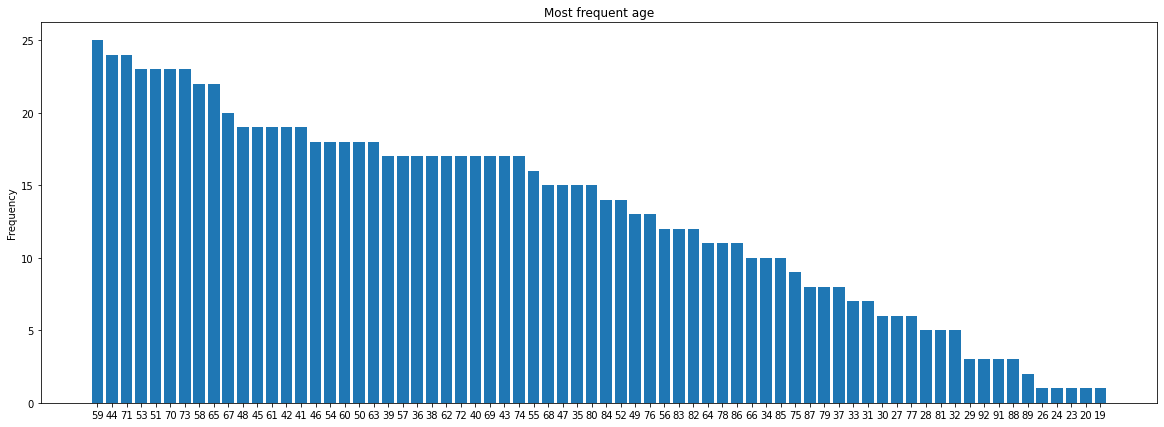

In [ ]:
plot_most_freq('age', 70)

Diagnosis

In [ ]:
trace_attributes_df.diagnosis.value_counts()

maligniteit cervix                             223
maligniteit ovarium | tuba                     123
maligniteit vulva                              123
Gynaecologische tumoren                         91
Maligne neoplasma cervix uteri                  67
                                              ... 
Cervixcarcinoom                                  1
Plav.celcarc. vulva: st IVb                      1
Niet epitheliale mal. nieuwv. ovarium st Ia      1
Ovariacarcinoom                                  1
Maligne nieuwvormingen darm (nno)                1
Name: diagnosis, Length: 78, dtype: int64

diagnosis_code

In [ ]:
trace_attributes_df.diagnosis_code.value_counts()

M13      247
M16      152
M11      144
DC106    132
M14       84
DC822     66
DC821     45
M12       16
M15       14
DC823      6
DC839      6
Name: diagnosis_code, dtype: int64

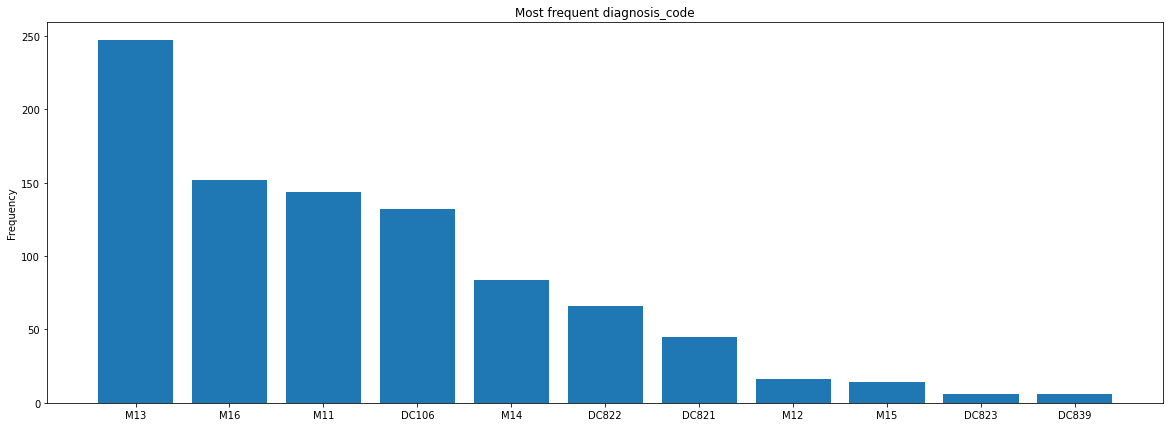

In [ ]:
plot_most_freq('diagnosis_code', 11)

diagnosis_treatment_combination_ID

In [ ]:
trace_attributes_df.diagnosis_treatment_combination_ID.value_counts()

DTC294835    1
DTC306431    1
DTC464771    1
DTC177184    1
DTC236512    1
            ..
DTC438605    1
DTC785776    1
DTC224677    1
DTC309433    1
DTC266024    1
Name: diagnosis_treatment_combination_ID, Length: 912, dtype: int64

specialism_code

In [ ]:
trace_attributes_df.specialism_code.value_counts()

SC7     682
SC61    188
SC13     42
Name: specialism_code, dtype: int64

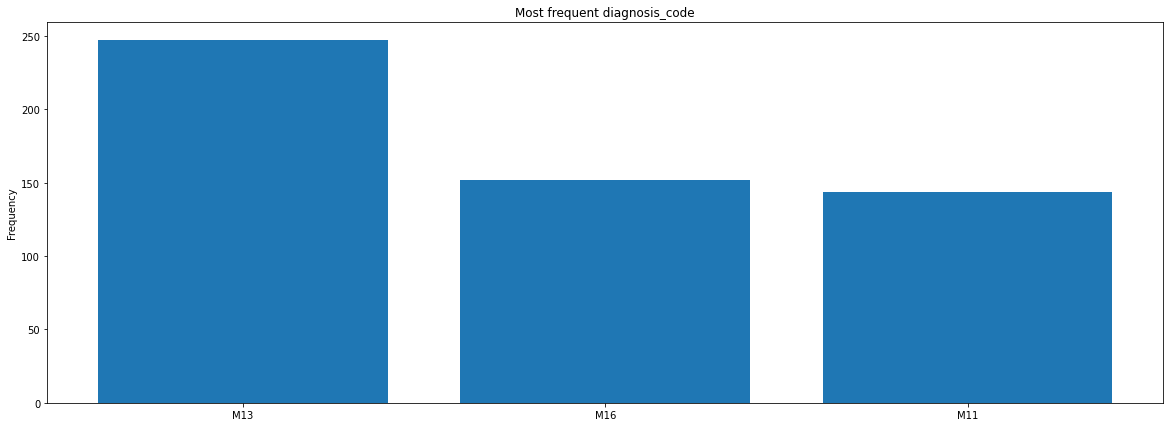

In [ ]:
plot_most_freq('diagnosis_code', 3)

treatment_code

In [ ]:
trace_attributes_df.treatment_code.value_counts()

TC101     412
TC803     114
TC61       85
TC3101     45
TC103      41
TC603      40
TC113      34
TC13       25
TC813      24
TC503      14
TC613      11
TC9101      9
TC23        9
TC3301      6
TC102       5
TC104       5
TC62        4
TC3201      3
TC12        3
TC81        3
TC703       3
TC11        3
TC4401      2
TC3103      2
TC5201      1
TC713       1
TC9102      1
TC3303      1
TC502       1
TC1101      1
TC32        1
TC501       1
TC3104      1
TC510       1
Name: treatment_code, dtype: int64

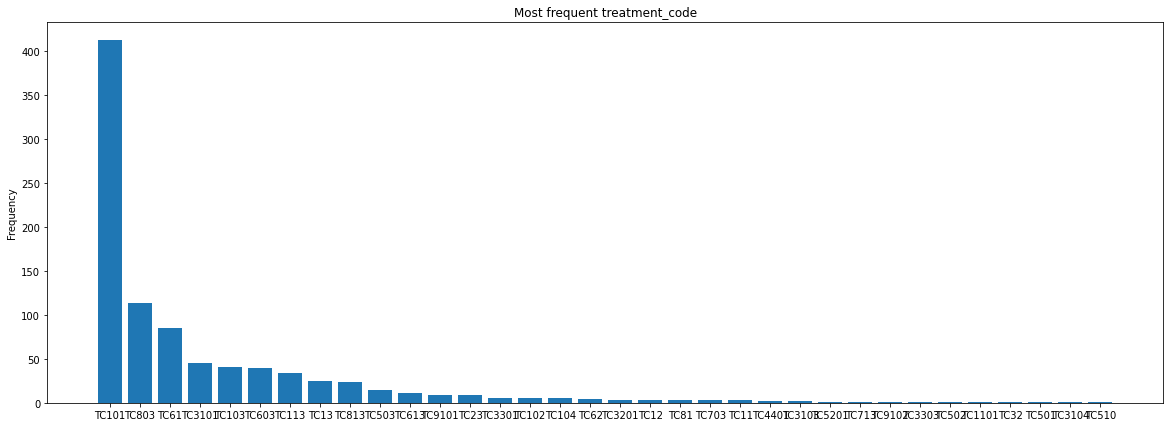

In [ ]:
plot_most_freq('treatment_code', 34)

label

In [ ]:
trace_attributes_df.label.value_counts()

false    563
true     349
Name: label, dtype: int64

In [ ]:
563/(563+349)

0.6173245614035088

Timestamp

In [ ]:
trace_attributes_df.readable_format_s

0      2005-01-03 00:14:24+01:00
1      2005-01-21 00:14:24+01:00
2      2006-01-28 00:14:24+01:00
3      2006-01-30 00:14:24+01:00
4      2006-01-03 00:14:24+01:00
                 ...            
907    2007-01-19 00:14:24+01:00
908    2007-01-11 00:14:24+01:00
909    2007-01-11 00:14:24+01:00
910    2007-01-16 00:14:24+01:00
911    2007-01-28 00:14:24+01:00
Name: readable_format_s, Length: 912, dtype: object

In [ ]:
trace_attributes_df.readable_format_s.value_counts()

2006-01-08 00:14:24+01:00    25
2006-01-18 00:14:24+01:00    23
2006-01-12 00:14:24+01:00    22
2006-01-06 00:14:24+01:00    21
2006-01-13 00:14:24+01:00    21
                             ..
2008-01-10 00:14:24+01:00     1
2008-01-16 00:14:24+01:00     1
2008-01-20 00:14:24+01:00     1
2007-01-13 00:14:24+01:00     1
2008-01-18 00:14:24+01:00     1
Name: readable_format_s, Length: 109, dtype: int64

In [ ]:
trace_attributes_df.epoch_s.value_counts()

1.136676e+09    25
1.137540e+09    23
1.137021e+09    22
1.137108e+09    21
1.137799e+09    21
                ..
1.200698e+09     1
1.200612e+09     1
1.200093e+09     1
1.168644e+09     1
1.199575e+09     1
Name: epoch_s, Length: 109, dtype: int64

In [ ]:
trace_attributes_df.readable_format_e

0      2005-01-29 23:45:36+01:00
1      2006-01-20 23:45:36+01:00
2      2007-01-27 23:45:36+01:00
3      2007-01-29 23:45:36+01:00
4      2008-01-02 23:45:36+01:00
                 ...            
907    2008-01-18 23:45:36+01:00
908    2007-01-31 23:45:36+01:00
909    2007-01-10 23:45:36+01:00
910    2007-01-23 23:45:36+01:00
911    2007-01-06 23:45:36+01:00
Name: readable_format_e, Length: 912, dtype: object

In [ ]:
trace_attributes_df.hour_minutes_s.value_counts()

014    912
Name: hour_minutes_s, dtype: int64

In [ ]:
trace_attributes_df.hour_minutes_e.value_counts()

2345    912
Name: hour_minutes_e, dtype: int64

In [ ]:
trace_attributes_df.month_s.value_counts()

1    912
Name: month_s, dtype: int64

In [ ]:
trace_attributes_df.day_of_week_s.value_counts()

5    154
7    152
1    142
6    129
2    122
4    109
3    104
Name: day_of_week_s, dtype: int64

In [ ]:
trace_attributes_df.day_of_year_s.value_counts()

8     40
21    39
12    37
10    37
7     37
6     34
18    34
14    34
29    34
19    33
17    32
3     31
27    31
13    30
9     30
2     29
28    29
16    29
1     28
30    27
22    26
15    25
20    25
26    25
11    24
24    24
25    24
4     23
5     22
23    21
31    18
Name: day_of_year_s, dtype: int64

In [ ]:
trace_attributes_df.month_e.value_counts()

1    912
Name: month_e, dtype: int64

Always the same month, hour and minute, so the variables
- month_s, 
- hour_s, 
- minute_s, 
- hour_minutes_s, 
- month_e, 
- hour_e, 
- minute_e, 
- hour_minutes_e 

are useless.

Moreover, keeping all other variables is not the best choice since they are redundant. A possible choice could be to keep only 
- day_of_year_s,
- day_of_week_s, 
- day_of_year_e, 
- day_of_week_e, 

and removing epoch_s, readable_format_s, epoch_e and readable_format_e.

Check also in the test set

In [ ]:
trace_with_end_date = 0
trace_without_end_date = 0

for case_index, case in enumerate(test):
    if 'End date' in case.attributes:
        trace_with_end_date += 1
    else:
        trace_without_end_date +=1
    
print(f'Traces with attribute End date = {trace_with_end_date}')
print(f'Traces without attribute End date = {trace_without_end_date}')

Traces with attribute End date = 116
Traces without attribute End date = 112


In [ ]:
trace_with_treatment_code = 0
trace_without_treatment_code = 0

for case_index, case in enumerate(test):
    if 'Treatment code' in case.attributes:
        trace_with_treatment_code += 1
    else:
        trace_without_treatment_code +=1
    
print(f'Traces with attribute Treatment code = {trace_with_treatment_code}')
print(f'Traces without attribute Treatment code = {trace_without_treatment_code}')

Traces with attribute Treatment code = 216
Traces without attribute Treatment code = 12


ATT: in the test set, there are some traces without attribute 'End date'. Maybe these are pre-mortem data. The same problem happens with attribute Treatment code. 

Since the number of traces without those attributes is significant, a possible choice is to remove those two attributes instead of removing the traces without them or add default values when needed.

Since it is not the main focus of this project, when I will consider also trace attributes I will discard End date and Treatment code.

In [ ]:
trace_attributes_data_test = []

for case_index, case in enumerate(test):
    t = [case.attributes['concept:name'],
        case.attributes['Age'],
        case.attributes['Diagnosis'],
        case.attributes['Diagnosis code'],
        case.attributes['Diagnosis Treatment Combination ID'],
        case.attributes['Specialism code'],
        # case.attributes['Treatment code'],
        # case.attributes['Start date'],
        # case.attributes['End date'],
        # case.attributes['label'],
        ]
    
    columns = ['name', 'age', 'diagnosis','diagnosis_code', 'diagnosis_treatment_combination_ID', 'specialism_code']

    t += encode_timestamp(case.attributes['Start date'])   
    columns += ['epoch_s', 'readable_format_s', 'day_of_year_s', 'day_of_week_s', 'month_s', 'hour_s', 'minutes_s', 'hour_minutes_s']
        
    # t += encode_timestamp(case.attributes['End date'])   
    # columns += ['epoch_e', 'readable_format_e', 'day_of_year_e', 'day_of_week_e', 'month_e', 'hour_e', 'minutes_e', 'hour_minutes_e']
    
    t.append(case.attributes["label"])
    columns.append('label')
    
    trace_attributes_data_test.append(t)

trace_attributes_df_test = pd.DataFrame(columns=columns, data=trace_attributes_data_test)
trace_attributes_df_test

,name,age,diagnosis,diagnosis_code,diagnosis_treatment_combination_ID,specialism_code,epoch_s,readable_format_s,day_of_year_s,day_of_week_s,month_s,hour_s,minutes_s,hour_minutes_s,label
0,00000912,51,Sereus adenoca: ovarium st IIIc,M16,DTC674183,SC7,1.167607e+09,2007-01-01 00:14:24+01:00,1,1,1,0,14,014,true
1,00000913,41,Adenoca: cervix st Ib,M13,DTC675876,SC7,1.167952e+09,2007-01-05 00:14:24+01:00,5,5,1,0,14,014,true
2,00000914,56,Adenoca: corpus uteri st Ib,M14,DTC847075,SC7,1.167952e+09,2007-01-05 00:14:24+01:00,5,5,1,0,14,014,true
3,00000915,66,Recidieven corpus maligniteit uteri (nno),M14,DTC677565,SC7,1.168125e+09,2007-01-07 00:14:24+01:00,7,7,1,0,14,014,true
4,00000916,64,"Plaveiselcelca, cervix st IIIb",M13,DTC690247,SC61,1.169853e+09,2007-01-27 00:14:24+01:00,27,6,1,0,14,014,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,00001138,55,"Plaveiselcelca, cervix st Ib",M13,DTC935157,SC7,1.200093e+09,2008-01-12 00:14:24+01:00,12,6,1,0,14,014,false
224,00001139,29,Sereus adenoca: ovarium st Ia,M16,DTC935160,SC7,1.200093e+09,2008-01-12 00:14:24+01:00,12,6,1,0,14,014,true
225,00001140,51,Plav.celcarc. vulva: st I,M11,DTC937197,SC7,1.200525e+09,2008-01-17 00:14:24+01:00,17,4,1,0,14,014,false
226,00001141,60,"Plaveiselcelca, cervix st Ib",M13,DTC938231,SC7,1.200612e+09,2008-01-18 00:14:24+01:00,18,5,1,0,14,014,false


In [ ]:
trace_attributes_df_test.describe(include='all')

,name,age,diagnosis,diagnosis_code,diagnosis_treatment_combination_ID,specialism_code,epoch_s,readable_format_s,day_of_year_s,day_of_week_s,month_s,hour_s,minutes_s,hour_minutes_s,label
count,228,228.000000,228,228,228,228,2.280000e+02,228,228.000000,228.000000,228.0,228.0,228.0,228,228
unique,228,NaN,74,11,228,3,NaN,56,NaN,NaN,NaN,NaN,NaN,1,2
top,00000921,NaN,"Plaveiselcelca, cervix st Ib",M13,DTC772449,SC7,NaN,2007-01-14 00:14:24+01:00,NaN,NaN,NaN,NaN,NaN,014,false
freq,1,NaN,28,64,1,171,NaN,10,NaN,NaN,NaN,NaN,NaN,228,119
mean,NaN,57.842105,NaN,NaN,NaN,NaN,1.176925e+09,NaN,16.000000,4.127193,1.0,0.0,14.0,NaN,NaN
std,NaN,15.835653,NaN,NaN,NaN,NaN,1.382664e+07,NaN,8.461887,2.016792,0.0,0.0,0.0,NaN,NaN
min,NaN,19.000000,NaN,NaN,NaN,NaN,1.167607e+09,NaN,1.000000,1.000000,1.0,0.0,14.0,NaN,NaN
25%,NaN,47.000000,NaN,NaN,NaN,NaN,1.168536e+09,NaN,9.000000,2.000000,1.0,0.0,14.0,NaN,NaN
50%,NaN,58.000000,NaN,NaN,NaN,NaN,1.169248e+09,NaN,16.000000,4.000000,1.0,0.0,14.0,NaN,NaN
75%,NaN,69.250000,NaN,NaN,NaN,NaN,1.199337e+09,NaN,23.000000,6.000000,1.0,0.0,14.0,NaN,NaN


Trace level attributes:

- 'name' - identifier
- 'age' - 70 values,
- 'diagnosis' - 78 values,
- 'diagnosis_code' - 11 values,
- 'diagnosis_treatment_combination_ID' - identifier,
- 'specialism_code' - 3 values,
- 'treatment_code' - 34 values - NO TEST SET,


- 'epoch_s' - 109 values,
- 'readable_format_s' - 109 values,
- 'day_of_year_s' - 31 values (training set),
- 'day_of_week_s' - 7 values,


- 'month_s'- 1 values,
- 'hour_s'- 1 values,
- 'minutes_s'- 1 values,
- 'hour_minutes_s'- 1 values,


- 'epoch_e' - NO TEST SET,
- 'readable_format_e' - NO TEST SET,
- 'day_of_year_e' - NO TEST SET,
- 'day_of_week_e' - NO TEST SET,
- 'month_e' - NO TEST SET,
- 'hour_e' - NO TEST SET,
- 'minutes_e' - NO TEST SET,
- 'hour_minutes_e' - NO TEST SET,


- 'label - 2 values: 563 false, 349 true'

To sum up, these are the trace attributes that may be useful for prediction:

- age                                   
- diagnosis                             
- diagnosis_code                        
- specialism_code                       


- (epoch_s)
- readable_format_s
- day_of_year_s                         
- day_of_week_s                         
                                        

- label                                 

### Event level attributes

In [ ]:
event

{'Activity code': 'AC410100', 'concept:name': 'First outpatient consultation', 'Specialism code': 'SC61', 'Producer code': 'SRTH', 'lifecycle:transition': 'complete', 'Section': 'Section 5', 'Number of executions': 1, 'time:timestamp': datetime.datetime(2005, 1, 3, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'group': 'Radiotherapy'}

In [ ]:
event_attributes = set()

for case_index, case in enumerate(train):
    for event_index, event in enumerate(case):
        event_attributes |= set(event.keys())

event_attributes

{'Activity code',
 'Number of executions',
 'Producer code',
 'Section',
 'Specialism code',
 'concept:name',
 'group',
 'lifecycle:transition',
 'time:timestamp'}

In [ ]:
event_with_Section = 0
event_without_Section = 0

for case_index, case in enumerate(train):
  for event_index, event in enumerate(case):
    if 'Section' in event.keys():
        event_with_Section += 1
    else:
        event_without_Section +=1
    
print(f'Events with attribute Section = {event_with_Section}')
print(f'Events without attribute Section = {event_without_Section}')

Events with attribute Section = 119699
Events without attribute Section = 16


In [ ]:
event_with_group = 0
event_without_group = 0

for case_index, case in enumerate(train):
  for event_index, event in enumerate(case):
    if 'group' in event.keys():
        event_with_group += 1
    else:
        event_without_group +=1
    
print(f'Events with attribute group = {event_with_group}')
print(f'Events without attribute group = {event_without_group}')

Events with attribute group = 119699
Events without attribute group = 16


In [ ]:
event_attributes_data = []

for case_index, case in enumerate(train):
  for event_index, event in enumerate(case):
    t = [event['concept:name'],
    event['Activity code'],
    event['Producer code'],
    event['Number of executions'],
    event['Specialism code'],
    event['lifecycle:transition'],
    # case.attributes['Start date'],
    # case.attributes['End date'],
    # case.attributes['label'],
    ]
    
    columns = ['name', 'activity_code', 'producer_code', 'number_of_executions',
            #    'section', 
               'specialism_code', 
               'lifecycle_transition',
            ]

    t += encode_timestamp(event['time:timestamp'])   
    columns += ['epoch', 'readable_format', 'day_of_year', 'day_of_week', 'month', 'hour', 'minutes', 'hour_minutes']
        
    # t += encode_timestamp(case.attributes['End date'])   
    # columns += ['epoch_e', 'readable_format_e', 'day_of_year_e', 'day_of_week_e', 'month_e', 'hour_e', 'minutes_e', 'hour_minutes_e']
    
    # t.append(case.attributes["label"])
    # columns.append('label')
    
    event_attributes_data.append(t)

event_attributes_df = pd.DataFrame(columns=columns, data=event_attributes_data)
event_attributes_df

,name,activity_code,producer_code,number_of_executions,specialism_code,lifecycle_transition,epoch,readable_format,day_of_year,day_of_week,month,hour,minutes,hour_minutes
0,First outpatient consultation,AC410100,SRTH,1,SC61,complete,1.104707e+09,2005-01-03 00:00:00+01:00,3,1,1,0,0,00
1,administrative fee - the first pol,AC419100,SRTH,1,SC61,complete,1.104707e+09,2005-01-03 00:00:00+01:00,3,1,1,0,0,00
2,verlosk.-gynaec. short-out card cost,AC10107,SGEH,1,SC7,complete,1.104880e+09,2005-01-05 00:00:00+01:00,5,3,1,0,0,00
3,ultrasound - internal genitals,339486E,SGEC,1,SC7,complete,1.104880e+09,2005-01-05 00:00:00+01:00,5,3,1,0,0,00
4,First outpatient consultation,AC410100,SGEH,1,SC7,complete,1.104880e+09,2005-01-05 00:00:00+01:00,5,3,1,0,0,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119710,order rate,AC379999,CRLA,1,SC86,complete,1.173136e+09,2007-03-06 00:00:00+01:00,65,2,3,0,0,00
119711,order rate,AC379999,CRLA,1,SC86,complete,1.173136e+09,2007-03-06 00:00:00+01:00,65,2,3,0,0,00
119712,order rate,AC379999,CRLA,1,SC86,complete,1.173136e+09,2007-03-06 00:00:00+01:00,65,2,3,0,0,00
119713,190205 Class 3b A205,AC613000,ICU6,1,SC7,complete,1.173136e+09,2007-03-06 00:00:00+01:00,65,2,3,0,0,00


In [ ]:
event_attributes_df.describe(include='all')

,name,activity_code,producer_code,number_of_executions,specialism_code,lifecycle_transition,epoch,readable_format,day_of_year,day_of_week,month,hour,minutes,hour_minutes
count,119715,119715,119715,119715.000000,119715,119715,1.197150e+05,119715,119715.000000,119715.000000,119715.000000,119715.000000,119715.0,119715
unique,582,627,113,NaN,23,1,NaN,1164,NaN,NaN,NaN,NaN,NaN,2
top,assumption laboratory,AC370000,CHE2,NaN,SC86,complete,NaN,2006-04-03 01:00:00+02:00,NaN,NaN,NaN,NaN,NaN,10
freq,12351,12351,25385,NaN,76155,119715,NaN,411,NaN,NaN,NaN,NaN,NaN,69826
mean,NaN,NaN,NaN,1.779994,NaN,NaN,1.150247e+09,NaN,178.652700,3.113085,6.380161,0.583269,0.0,NaN
std,NaN,NaN,NaN,15.526018,NaN,NaN,2.424967e+07,NaN,105.635138,1.735286,3.464436,0.493020,0.0,NaN
min,NaN,NaN,NaN,-300.000000,NaN,NaN,1.104707e+09,NaN,1.000000,1.000000,1.000000,0.000000,0.0,NaN
25%,NaN,NaN,NaN,1.000000,NaN,NaN,1.130972e+09,NaN,82.000000,2.000000,3.000000,0.000000,0.0,NaN
50%,NaN,NaN,NaN,1.000000,NaN,NaN,1.149721e+09,NaN,179.000000,3.000000,6.000000,1.000000,0.0,NaN
75%,NaN,NaN,NaN,1.000000,NaN,NaN,1.167174e+09,NaN,271.000000,4.000000,9.000000,1.000000,0.0,NaN


In [ ]:
# Auxiliary function to plot the distribution of some attributes

def plot_most_freq(variable, k):

    '''plot the frequency of the k most frequent values of a variable'''

    vc = event_attributes_df[variable].value_counts() # count values 

    if k == event_attributes_df[variable].nunique():
        v = vc.values
        i = vc.index
    
    else: 
        v = vc[:k].values
        i = vc[:k].index

    fig, ax = plt.subplots(figsize=(20,7))
    ax.bar(range(k), v)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Most frequent {variable}')
    # ax.set_xticks(np.arange(k))
    # ax.set_xticklabels(i)
    plt.show()

Name

In [ ]:
event_attributes_df.name.value_counts()

assumption laboratory                       12351
demurrage - all spec.beh.kinderg.-Reval.     8295
order rate                                   7235
190205 Class 3b A205                         7128
outpatient follow-up consultation            4766
                                            ...  
g IgG immunoglobulin                            1
Complement deficiency ond.bij afwezigh.a        1
cvvhd - continuous veno-venous hemo             1
tuba-uterine cyst excision parovariale          1
e.m.g. - Electromyographic researc              1
Name: name, Length: 582, dtype: int64

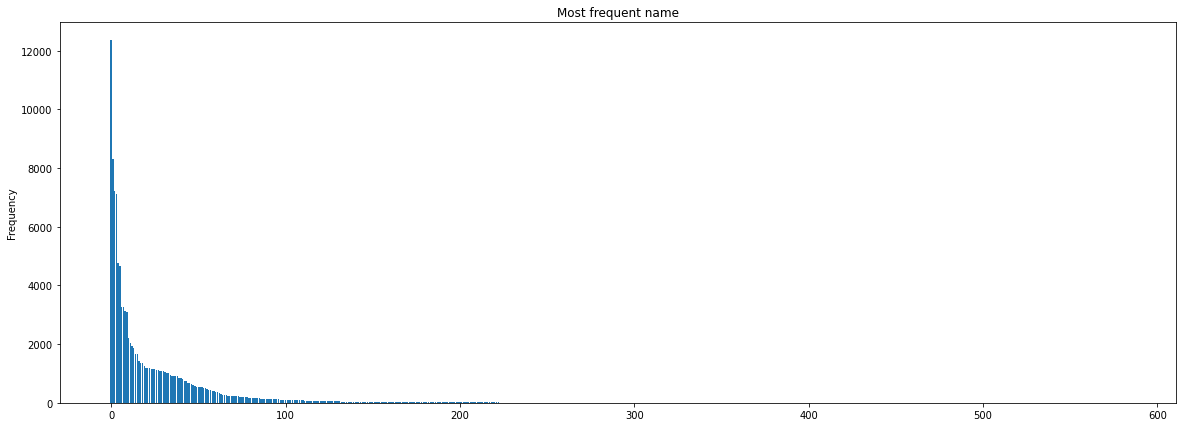

In [ ]:
plot_most_freq('name', 582)

activity_code

In [ ]:
event_attributes_df.activity_code.value_counts()

AC370000    12351
AC40014      8295
AC379999     7235
AC613000     7128
AC411100     4766
            ...  
376406B         1
337193A         1
378718E         1
AC333270        1
AC333720        1
Name: activity_code, Length: 627, dtype: int64

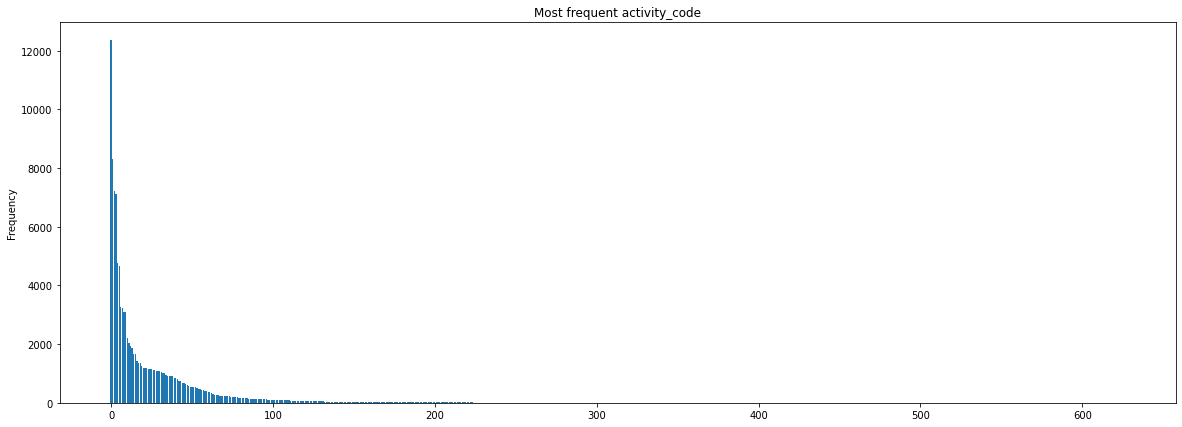

In [ ]:
plot_most_freq('activity_code', 627)

producer_code

In [ ]:
event_attributes_df.producer_code.value_counts()

CHE2    25385
H5ZU    22841
CRLA    17213
HAEM    11763
CRLE     9919
        ...  
SUOB        1
POZK        1
H6ZN        1
INFZ        1
F3NO        1
Name: producer_code, Length: 113, dtype: int64

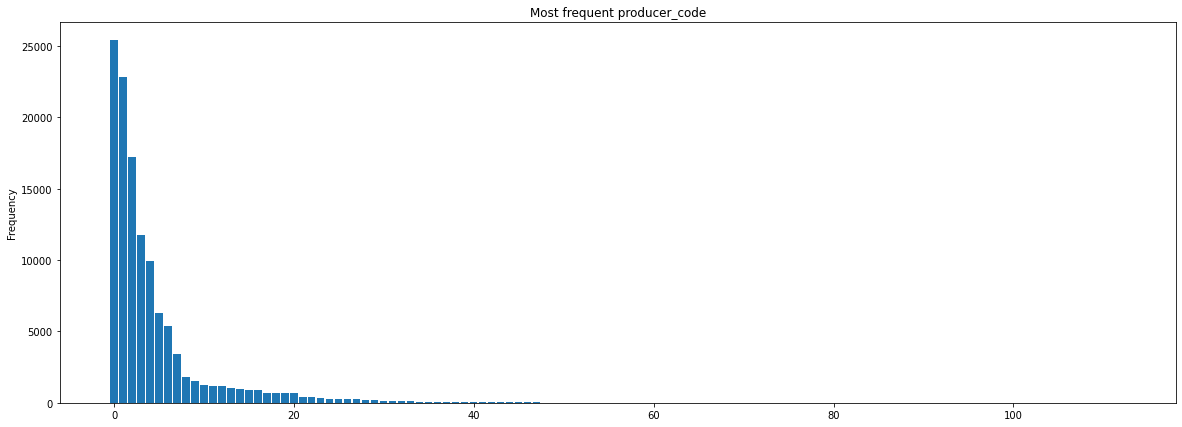

In [ ]:
plot_most_freq('producer_code', 113)

specialism_code

In [ ]:
event_attributes_df.specialism_code.value_counts()

SC86    76155
SC7     30066
SC87     3482
SC61     2889
SC62     2379
SC13     1991
SC88     1502
SC89      360
SC20      235
SC63      233
SC99      209
SC3       130
SC2        19
SC18       15
SC27       14
SC22       13
SC30       10
SC6         6
SC0         2
SC29        2
SC28        1
SC24        1
SC90        1
Name: specialism_code, dtype: int64

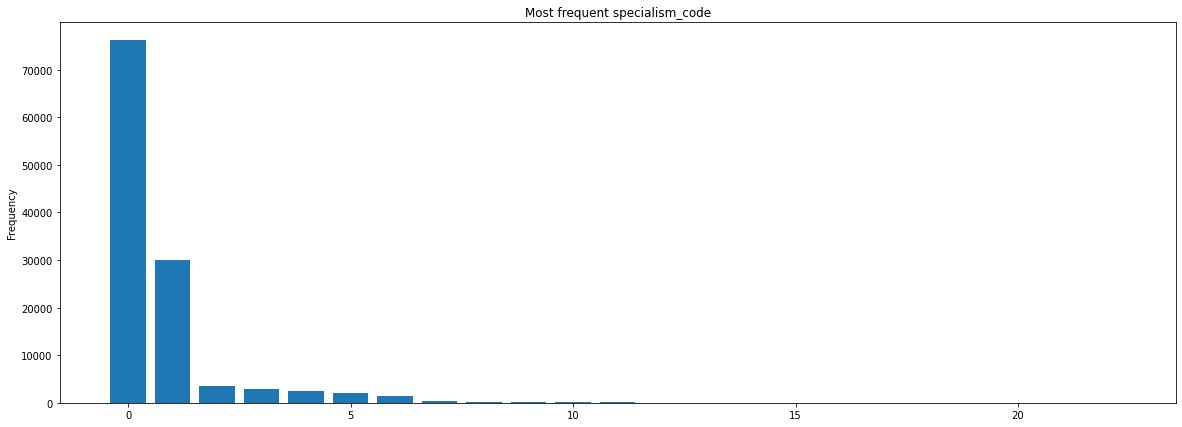

In [ ]:
plot_most_freq('specialism_code', 23)

 Number of executions

In [ ]:
event_attributes_df.number_of_executions.value_counts()

 1      118283
-1         882
 300       158
 200        95
 4          51
 100        47
 30         24
 60         23
 10         23
 2          17
 175        17
 400        13
 20         10
 90          7
 600         7
 80          7
 3           6
 330         6
 800         5
 40          4
-200         4
 130         4
 160         3
 120         2
 500         2
-20          2
 11          2
 230         2
-300         2
 460         1
 8           1
 5           1
 13          1
 14          1
-2           1
 320         1
Name: number_of_executions, dtype: int64

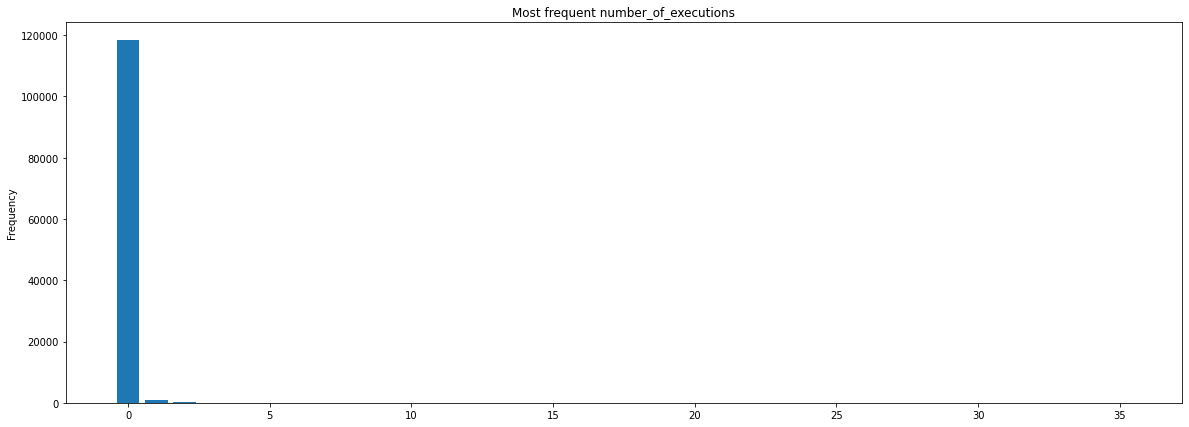

In [ ]:
plot_most_freq('number_of_executions', 36)

 lifecycle:transition

In [ ]:
event_attributes_df.lifecycle_transition.value_counts()

complete    119715
Name: lifecycle_transition, dtype: int64

Timestamp

In [ ]:
event_attributes_df.readable_format

0         2005-01-03 00:00:00+01:00
1         2005-01-03 00:00:00+01:00
2         2005-01-05 00:00:00+01:00
3         2005-01-05 00:00:00+01:00
4         2005-01-05 00:00:00+01:00
                    ...            
119710    2007-03-06 00:00:00+01:00
119711    2007-03-06 00:00:00+01:00
119712    2007-03-06 00:00:00+01:00
119713    2007-03-06 00:00:00+01:00
119714    2007-03-06 00:00:00+01:00
Name: readable_format, Length: 119715, dtype: object

In [ ]:
event_attributes_df.readable_format.value_counts()

2006-04-03 01:00:00+02:00    411
2006-12-11 00:00:00+01:00    361
2006-08-30 01:00:00+02:00    351
2006-06-06 01:00:00+02:00    347
2006-06-14 01:00:00+02:00    342
                            ... 
2007-11-25 00:00:00+01:00      2
2007-06-24 01:00:00+02:00      2
2007-11-10 00:00:00+01:00      2
2007-11-11 00:00:00+01:00      2
2005-01-08 00:00:00+01:00      1
Name: readable_format, Length: 1164, dtype: int64

In [ ]:
event_attributes_df.epoch.value_counts()

1.144019e+09    411
1.165792e+09    361
1.156892e+09    351
1.149548e+09    347
1.150240e+09    342
               ... 
1.194649e+09      2
1.194736e+09      2
1.198537e+09      2
1.195945e+09      2
1.105139e+09      1
Name: epoch, Length: 1164, dtype: int64

In [ ]:
event_attributes_df.hour.value_counts()

1    69826
0    49889
Name: hour, dtype: int64

In [ ]:
event_attributes_df.minutes.value_counts()

0    119715
Name: minutes, dtype: int64

In [ ]:
event_attributes_df.hour_minutes.value_counts()

10    69826
00    49889
Name: hour_minutes, dtype: int64

In [ ]:
event_attributes_df.month.value_counts()

3     11638
2     10698
10    10672
1     10447
9     10156
7      9880
6      9734
5      9565
8      9393
11     9325
12     9123
4      9084
Name: month, dtype: int64

In [ ]:
event_attributes_df.day_of_year.value_counts()

165    735
108    687
46     671
276    653
25     607
      ... 
359     81
148     75
231     61
1       54
120     53
Name: day_of_year, Length: 365, dtype: int64

In [ ]:
event_attributes_df.day_of_week.value_counts()

1    29804
3    22430
4    21506
2    18998
5    15777
6     5716
7     5484
Name: day_of_week, dtype: int64

Event level attributes:

- 'name' - 582 values,
- 'activity_code' - 627 values,
- 'producer_code' - 113 values,
- 'number_of_executions' - almost always 1,
- 'specialism_code' - 23 values,
- 'lifecycle_transition' - 1 value,


- 'epoch' - 1164 values,
- 'readable_format' - 1164 values,
- 'day_of_year' - 365 values,
- 'day_of_week' - 7 values,
- 'month' - 12 values,
- 'hour' - 2 values,
- 'minutes' - 1 value,
- 'hour_minutes - 2 values'

Tu sum up, the event level attributes that could be relevant are:

- name, 
- activity_code, 
- producer_code, 
- specialism_code, 


- (epoch)
- readable format
- day_of_year, 
- day_of_week, 
- month
- hour




Check also the test set

In [ ]:
event_attributes_data_test = []

for case_index, case in enumerate(test):
  for event_index, event in enumerate(case):
    t = [event['concept:name'],
    event['Activity code'],
    event['Producer code'],
    event['Number of executions'],
    event['Specialism code'],
    event['lifecycle:transition'],
    # case.attributes['Start date'],
    # case.attributes['End date'],
    # case.attributes['label'],
    ]
    
    columns = ['name', 'activity_code', 'producer_code', 'number_of_executions',
            #    'section', 
               'specialism_code', 
               'lifecycle_transition',
            ]

    t += encode_timestamp(event['time:timestamp'])   
    columns += ['epoch', 'readable_format', 'day_of_year', 'day_of_week', 'month', 'hour', 'minutes', 'hour_minutes']
        
    # t += encode_timestamp(case.attributes['End date'])   
    # columns += ['epoch_e', 'readable_format_e', 'day_of_year_e', 'day_of_week_e', 'month_e', 'hour_e', 'minutes_e', 'hour_minutes_e']
    
    # t.append(case.attributes["label"])
    # columns.append('label')
    
    event_attributes_data_test.append(t)

event_attributes_test_df = pd.DataFrame(columns=columns, data=event_attributes_data_test)
event_attributes_test_df

,name,activity_code,producer_code,number_of_executions,specialism_code,lifecycle_transition,epoch,readable_format,day_of_year,day_of_week,month,hour,minutes,hour_minutes
0,assumption laboratory,AC370000,CRPO,1,SC86,complete,1.172704e+09,2007-03-01 00:00:00+01:00,60,4,3,0,0,00
1,assumption laboratory,AC370000,CRPO,1,SC86,complete,1.172704e+09,2007-03-01 00:00:00+01:00,60,4,3,0,0,00
2,assumption laboratory,AC370000,CRPO,1,SC86,complete,1.172704e+09,2007-03-01 00:00:00+01:00,60,4,3,0,0,00
3,unconjugated bilirubin,AC370401,CHE2,1,SC86,complete,1.172704e+09,2007-03-01 00:00:00+01:00,60,4,3,0,0,00
4,bilirubin - total,370401C,CHE2,1,SC86,complete,1.172704e+09,2007-03-01 00:00:00+01:00,60,4,3,0,0,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30010,calcium,377498A,CHE2,1,SC86,complete,1.205968e+09,2008-03-20 00:00:00+01:00,80,4,3,0,0,00
30011,albumin,378453A,CHE2,1,SC86,complete,1.205968e+09,2008-03-20 00:00:00+01:00,80,4,3,0,0,00
30012,red cell antibody screening,AC378607,BLOB,1,SC86,complete,1.205968e+09,2008-03-20 00:00:00+01:00,80,4,3,0,0,00
30013,differentiation leukocytes - manual,379000A,HAEM,1,SC86,complete,1.205968e+09,2008-03-20 00:00:00+01:00,80,4,3,0,0,00


In [ ]:
event_attributes_test_df.describe(include='all')

,name,activity_code,producer_code,number_of_executions,specialism_code,lifecycle_transition,epoch,readable_format,day_of_year,day_of_week,month,hour,minutes,hour_minutes
count,30015,30015,30015,30015.000000,30015,30015,3.001500e+04,30015,30015.000000,30015.000000,30015.000000,30015.000000,30015.0,30015
unique,316,341,65,NaN,18,1,NaN,382,NaN,NaN,NaN,NaN,NaN,2
top,assumption laboratory,AC370000,H5ZU,NaN,SC86,complete,NaN,2007-05-16 01:00:00+02:00,NaN,NaN,NaN,NaN,NaN,10
freq,2942,2942,6786,NaN,19070,30015,NaN,323,NaN,NaN,NaN,NaN,NaN,16777
mean,NaN,NaN,NaN,1.567016,NaN,NaN,1.190844e+09,NaN,194.073996,3.085924,6.863168,0.558954,0.0,NaN
std,NaN,NaN,NaN,13.371606,NaN,NaN,8.604011e+06,NaN,107.296904,1.734352,3.513850,0.496521,0.0,NaN
min,NaN,NaN,NaN,-300.000000,NaN,NaN,1.172704e+09,NaN,1.000000,1.000000,1.000000,0.000000,0.0,NaN
25%,NaN,NaN,NaN,1.000000,NaN,NaN,1.184368e+09,NaN,96.000000,1.000000,4.000000,0.000000,0.0,NaN
50%,NaN,NaN,NaN,1.000000,NaN,NaN,1.190761e+09,NaN,204.000000,3.000000,7.000000,1.000000,0.0,NaN
75%,NaN,NaN,NaN,1.000000,NaN,NaN,1.198105e+09,NaN,282.000000,4.000000,10.000000,1.000000,0.0,NaN


Get the list of all event names. This will be used for the Label Encoder

In [ ]:
event_names = set(event_attributes_df.name) | set(event_attributes_test_df.name)
event_names = list(event_names) + ['']
event_names

['crossmatch methods, three fully-',
 'cde phenotyping',
 'ovarian - ovarian cancer debulking',
 'IV - Blood',
 'creatinine phosphokinase - urgent',
 'infusion - insertion',
 'morphometry',
 'heart - feature gated blood pool rest',
 'thrombo',
 'anesthesia - when treated with radium',
 'Pleural - puncture - Diagnostic',
 'SGPT - alat kinetic',
 'antigen detection - direct preparation - vz',
 't3-uptake latent bindingscap. geb. tbg',
 'anesthesia - epidural blood patch',
 'ct pelvis',
 'spine - thoracic',
 'cortisol immunofluorescence colorimetric',
 'erythrocytes',
 'ultrasound and X-ray like ass. by drainage ab',
 'lymph gland - scint dynamic sentinel node',
 'peritoneum - omentectomy',
 'gut - stoma catheterisation',
 'interc. consult clinical radiotherapy',
 'ABO blood group determination other than kidd',
 'antist. HIV or HIV-e-c',
 'aluminum',
 'protein electrophoresis kwn spectrum. bep. f',
 'cytology - endocervix -',
 'colon walk',
 'cytology - vagina -',
 'microscopic examinati

# Create datasets

Before creating the datasets with different features, I also implement two auxiliary functions that can be used to add also event level attributes.

In [ ]:
def encode_event_complex(event):

    timestamp = event['time:timestamp'] 
    time_vector = encode_timestamp(timestamp)

    # concatenate the event attributes with the time vector
    event_complex = [event['concept:name'], event['Activity code'], event['Producer code'], event['Specialism code']] + time_vector

    return event_complex

In [ ]:
def encode_trace_complex(trace):

    events = []

    for event_index, event in enumerate(trace):
        # Compute prefix iterating over the trace, but stop if the length is higher than 20
        if event_index < 20:
            events += encode_event_complex(event)

    # Implement padding by adding an enpty string if the trace length is smaller than 20 
    # Att: event_index is zero-based
    while event_index < 19:
        events += ['', '', '', '', 0.0, '0000-00-00 00:00:00+01:00', 0, 0, 0, 0, 0, '00']
        event_index += 1

    return events

Now let's write a function that creates the dataset. It takes as input the log and some parameters, which are used to choose the information that will be used. If they are all set to false, then, simple index encoding is applied. Otherwise we can choose to add event timestamps, trace timestamps, trace attributes and event attributes. 

In [ ]:
def create_dataset(log, event_timestamps=False, trace_attributes=False, trace_timestamps=False, complex_encoding=False):

    ### Generate data
    data = []

    for case_index, case in enumerate(log):
        
        if event_timestamps == False:
            # Simple index encoding
            t = encode_trace_simple_index(case) 

        else:
            if complex_encoding == False:
                # Simple index encoding with timestamp
                temp = encode_trace_simple_index_with_timestamp(case)
                # I want to keep only significant attributes, and they are in positions 0, 2, 3, 4, 5, 6.
                to_keep = sorted([i*9 for i in range(20)] + [i*9 + 2 for i in range(20)] + [i*9 + 3 for i in range(20)] + [i*9 + 4 for i in range(20)] + [i*9 + 5 for i in range(20)] + [i*9 + 6 for i in range(20)])
                t = [temp[x] for x in to_keep]
            else:
                # Complex index encoding
                temp = encode_trace_complex(case)
                to_keep = sorted([i*12 for i in range(20)] + [i*12 + 2 for i in range(20)] + [i*12 + 3 for i in range(20)] + [i*12 + 5 for i in range(20)] + [i*12 + 6 for i in range(20)] + [i*12 + 7 for i in range(20)] + [i*12 + 8 for i in range(20)]  + [i*12 + 9 for i in range(20)])
                t = [temp[x] for x in to_keep]

        if trace_attributes == True:
            # Trace attributes
            t += [# case.attributes['concept:name'],
                  case.attributes['Age'],
                  case.attributes['Diagnosis'], 
                  case.attributes['Diagnosis code'],
                  # case.attributes['Diagnosis Treatment Combination ID'],
                  case.attributes['Specialism code'],
                  # case.attributes['Treatment code']
                  ]

        if trace_timestamps == True:
            # Trace timestamp attributes
            t += encode_timestamp(case.attributes['Start date'])[1:4]
        
        # Label
        t.append(case.attributes["label"])
        
        data.append(t)


    ### Generate column names

    if event_timestamps == False:
        # Generate column names for the events
        columns = [f'event_{i+1}' for i in range(20)]

    else:
        if complex_encoding == False:
            # Generate column names for the events and timestamps
            # columns = [[f'event_{i+1}', f'epoch_{i+1}', f'readable_format_{i+1}', 
            #             f'day_of_year_{i+1}', f'day_of_week_{i+1}', f'month_{i+1}', 
            #             f'hour_{i+1}', f'minutes_{i+1}', f'hour_minutes_{i+1}']
            #            for i in range(20)]
            columns = [[f'event_{i+1}', f'readable_format_{i+1}', 
                        f'day_of_year_{i+1}', f'day_of_week_{i+1}', f'month_{i+1}', 
                        f'hour_{i+1}']
                       for i in range(20)]
            columns = [att for event_att_list in columns for att in event_att_list]

        else:
            columns = [[f'event_{i+1}', 
                        # f'activity_code_{i+1}', 
                        f'producer_code_{i+1}', 
                        f'specialism_code_{i+1}', f'readable_format_{i+1}', 
                        f'day_of_year_{i+1}', f'day_of_week_{i+1}', f'month_{i+1}', 
                        f'hour_{i+1}']
                        for i in range(20)]
            columns = [att for event_att_list in columns for att in event_att_list]

    if trace_attributes == True:
        # Generate column names for the trace attributes
        # columns += ['name', 'age', 'diagnosis','diagnosis_code', 'diagnosis_treatment_combination_ID', 'specialism_code', 'treatment_code']
        columns += ['age', 'diagnosis', 'diagnosis_code', 'specialism_code']
                        
    if trace_timestamps == True:
        # Generate column names for the trace timestamp attributes
        columns += ['readable_format_s', 'day_of_year_s', 'day_of_week_s']
    
    # Generate column name for the label
    columns.append('label')

    log_df = pd.DataFrame(columns=columns, data=data)
    return log_df
    

Function to perform the encoding of categorical features

In [ ]:
event_columns = [f'event_{i+1}' for i in range(20)]

def encode_categorical(log):

    encoder = preprocessing.LabelEncoder()
    encoder.fit(list(event_names))    
    for e in event_columns:
        log[e] = encoder.transform(log[e])

    other_categorical_columns = set(log.columns) - set(log._get_numeric_data().columns) - set(event_columns)

    for c in other_categorical_columns:
        encoder = preprocessing.LabelEncoder()
        encoder.fit(list(set(log[c].unique())))    
        log[c] = encoder.transform(log[c])

    return log

### Simple index encoding

In [ ]:
df_simple = create_dataset(train, event_timestamps=False, trace_attributes=False, trace_timestamps=False, complex_encoding=False)
df_simple_t = create_dataset(test, event_timestamps=False, trace_attributes=False, trace_timestamps=False, complex_encoding=False)
df_simple

,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20,label
0,First outpatient consultation,administrative fee - the first pol,verlosk.-gynaec. short-out card cost,ultrasound - internal genitals,First outpatient consultation,administrative fee - the first pol,simulator - use before megavol,treatment time - Unit t3 - megavolt,teletherapy - megavolt photons bestrali,assumption laboratory,assumption laboratory,urea,hemoglobin photoelectric,creatinine,sodium flame photometry,potassium potentiometrically,leukocyte count electronic,platelet count - Electronic,order rate,demurrage - all spec.beh.kinderg.-Reval.,false
1,inwend.geneesk. short-out card cost,First outpatient consultation,administrative fee - the first pol,verlosk.-gynaec. short-out card cost,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,demurrage - all spec.beh.kinderg.-Reval.,assumption laboratory,assumption laboratory,assumption laboratory,creatinine - urgent,iron,sodium - flame photometry - urgent,Potassium flame photometry - urgent,folate using radioisotopes,vitamin B12 using chemieluminescentie,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,differential count automatically,false
2,inwend.geneesk. short-out card cost,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,inwend.geneesk. aanv.kaart cost-Out,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,assumption laboratory,squamous cell carcinoma using eia,ca-125 using meia,order rate,outpatient follow-up consultation,ct abdomen,telephone consultation,true
3,inwend.geneesk. short-out card cost,assumption laboratory,urine analysis - qualitative,order rate,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,outpatient follow-up consultation,inwend.geneesk. aanv.kaart cost-Out,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,gay cystine chromatography,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,telephone consultation,outpatient follow-up consultation,outpatient follow-up consultation,false
4,verlosk.-gynaec. short-out card cost,cytology - ectocervix -,assumption laboratory,assumption laboratory,assumption laboratory,unconjugated bilirubin,bilirubin - total,glucose,urea,hemoglobin photoelectric,creatinine,alkaline phosphatase-kinetic-,sodium flame photometry,potassium potentiometrically,SGOT - Asat kinetic,SGPT - alat kinetic,Milk acid dehydrogenase LDH kinetic,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,leukocyte count electronic,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,assumption laboratory,assumption laboratory,assumption laboratory,unconjugated bilirubin,bilirubin - total,glucose,urea,hemoglobin photoelectric,creatinine,alkaline phosphatase-kinetic-,sodium flame photometry,potassium potentiometrically,SGOT - Asat kinetic,SGPT - alat kinetic,Milk acid dehydrogenase LDH kinetic,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,leukocyte count electronic,platelet count - Electronic,gammaglutamyltranspeptidase,false
908,histological examination - biopsies nno,assumption laboratory,assumption laboratory,assumption laboratory,unconjugated bilirubin,bilirubin - total,glucose,urea,hemoglobin photoelectric,creatinine,alkaline phosphatase-kinetic-,sodium flame photometry,potassium potentiometrically,SGOT - Asat kinetic,SGPT - alat kinetic,Milk ac

In [ ]:
# To perform the categorical encoding and possibly to perform cross-validation, merge the training and test set
df_simple_all = pd.concat([df_simple, df_simple_t])
df_simple_all_enc = encode_categorical(df_simple_all)
df_simple, df_simple_t = train_test_split(df_simple_all_enc, test_size=0.2, random_state=22, stratify=df_simple_all_enc.label)

### Simple index encoding + trace attributes

In [ ]:
df_simple_trace = create_dataset(train, event_timestamps=False, trace_attributes=True, trace_timestamps=False, complex_encoding=False)
df_simple_trace_t = create_dataset(test, event_timestamps=False, trace_attributes=True, trace_timestamps=False, complex_encoding=False)
df_simple_trace

,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,event_11,event_12,event_13,event_14,event_15,event_16,event_17,event_18,event_19,event_20,age,diagnosis,diagnosis_code,specialism_code,label
0,First outpatient consultation,administrative fee - the first pol,verlosk.-gynaec. short-out card cost,ultrasound - internal genitals,First outpatient consultation,administrative fee - the first pol,simulator - use before megavol,treatment time - Unit t3 - megavolt,teletherapy - megavolt photons bestrali,assumption laboratory,assumption laboratory,urea,hemoglobin photoelectric,creatinine,sodium flame photometry,potassium potentiometrically,leukocyte count electronic,platelet count - Electronic,order rate,demurrage - all spec.beh.kinderg.-Reval.,33,maligniteit cervix,M13,SC61,false
1,inwend.geneesk. short-out card cost,First outpatient consultation,administrative fee - the first pol,verlosk.-gynaec. short-out card cost,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,demurrage - all spec.beh.kinderg.-Reval.,assumption laboratory,assumption laboratory,assumption laboratory,creatinine - urgent,iron,sodium - flame photometry - urgent,Potassium flame photometry - urgent,folate using radioisotopes,vitamin B12 using chemieluminescentie,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,differential count automatically,39,maligniteit cervix,DC822,SC7,false
2,inwend.geneesk. short-out card cost,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,inwend.geneesk. aanv.kaart cost-Out,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,assumption laboratory,squamous cell carcinoma using eia,ca-125 using meia,order rate,outpatient follow-up consultation,ct abdomen,telephone consultation,52,maligniteit cervix,DC822,SC7,true
3,inwend.geneesk. short-out card cost,assumption laboratory,urine analysis - qualitative,order rate,outpatient follow-up consultation,administrative fee - the first pol,outpatient follow-up consultation,outpatient follow-up consultation,inwend.geneesk. aanv.kaart cost-Out,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,gay cystine chromatography,outpatient follow-up consultation,outpatient follow-up consultation,outpatient follow-up consultation,administrative fee - the first pol,telephone consultation,outpatient follow-up consultation,outpatient follow-up consultation,56,maligniteit ovarium,DC821,SC7,false
4,verlosk.-gynaec. short-out card cost,cytology - ectocervix -,assumption laboratory,assumption laboratory,assumption laboratory,unconjugated bilirubin,bilirubin - total,glucose,urea,hemoglobin photoelectric,creatinine,alkaline phosphatase-kinetic-,sodium flame photometry,potassium potentiometrically,SGOT - Asat kinetic,SGPT - alat kinetic,Milk acid dehydrogenase LDH kinetic,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,leukocyte count electronic,31,maligniteit ovarium | tuba,M16,SC7,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,assumption laboratory,assumption laboratory,assumption laboratory,unconjugated bilirubin,bilirubin - total,glucose,urea,hemoglobin photoelectric,creatinine,alkaline phosphatase-kinetic-,sodium flame photometry,potassium potentiometrically,SGOT - Asat kinetic,SGPT - alat kinetic,Milk acid dehydrogenase LDH kinetic,ABO blood group and rhesus factor,rhesus factor d - Centrifuge method - email,leukocyte count electronic,platelet count - Electronic,gammaglutamyltranspeptidase,37,"Plaveiselcelca, cervix st Ia1",M13,SC7,false
908,histological examination - biopsies nno,assumption labor

In [ ]:
# To perform the categorical encoding and possibly to perform cross-validation, merge the training and test set
df_simple_trace_all = pd.concat([df_simple_trace, df_simple_trace_t])
df_simple_trace_all_enc = encode_categorical(df_simple_trace_all)
df_simple_trace, df_simple_trace_t = train_test_split(df_simple_trace_all_enc, test_size=0.2, random_state=22, stratify=df_simple_trace_all_enc.label)

### Simple index encoding + timestamps

In [ ]:
df_time = create_dataset(train, event_timestamps=True, trace_attributes=False, trace_timestamps=False, complex_encoding=False)
df_time_t = create_dataset(test, event_timestamps=True, trace_attributes=False, trace_timestamps=False, complex_encoding=False)
df_time

,event_1,readable_format_1,day_of_year_1,day_of_week_1,month_1,hour_1,event_2,readable_format_2,day_of_year_2,day_of_week_2,month_2,hour_2,event_3,readable_format_3,day_of_year_3,day_of_week_3,month_3,hour_3,event_4,readable_format_4,day_of_year_4,day_of_week_4,month_4,hour_4,event_5,readable_format_5,day_of_year_5,day_of_week_5,month_5,hour_5,event_6,readable_format_6,day_of_year_6,day_of_week_6,month_6,hour_6,event_7,readable_format_7,day_of_year_7,day_of_week_7,...,day_of_week_14,month_14,hour_14,event_15,readable_format_15,day_of_year_15,day_of_week_15,month_15,hour_15,event_16,readable_format_16,day_of_year_16,day_of_week_16,month_16,hour_16,event_17,readable_format_17,day_of_year_17,day_of_week_17,month_17,hour_17,event_18,readable_format_18,day_of_year_18,day_of_week_18,month_18,hour_18,event_19,readable_format_19,day_of_year_19,day_of_week_19,month_19,hour_19,event_20,readable_format_20,day_of_year_20,day_of_week_20,month_20,hour_20,label
0,First outpatient consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,2005-01-05 00:00:00+01:00,5,3,1,0,ultrasound - internal genitals,2005-01-05 00:00:00+01:00,5,3,1,0,First outpatient consultation,2005-01-05 00:00:00+01:00,5,3,1,0,administrative fee - the first pol,2005-01-05 00:00:00+01:00,5,3,1,0,simulator - use before megavol,2005-01-24 00:00:00+01:00,24,1,...,2,2,0,sodium flame photometry,2005-02-15 00:00:00+01:00,46,2,2,0,potassium potentiometrically,2005-02-15 00:00:00+01:00,46,2,2,0,leukocyte count electronic,2005-02-15 00:00:00+01:00,46,2,2,0,platelet count - Electronic,2005-02-15 00:00:00+01:00,46,2,2,0,order rate,2005-02-15 00:00:00+01:00,46,2,2,0,demurrage - all spec.beh.kinderg.-Reval.,2005-02-17 00:00:00+01:00,48,4,2,0,false
1,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,First outpatient consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,2005-01-06 00:00:00+01:00,6,4,1,0,outpatient follow-up consultation,2005-01-06 00:00:00+01:00,6,4,1,0,administrative fee - the first pol,2005-01-06 00:00:00+01:00,6,4,1,0,outpatient follow-up consultation,2005-01-10 00:00:00+01:00,10,1,...,3,1,0,Potassium flame photometry - urgent,2005-01-19 00:00:00+01:00,19,3,1,0,folate using radioisotopes,2005-01-19 00:00:00+01:00,19,3,1,0,vitamin B12 using chemieluminescentie,2005-01-19 00:00:00+01:00,19,3,1,0,ABO blood group and rhesus factor,2005-01-19 00:00:00+01:00,19,3,1,0,rhesus factor d - Centrifuge method - email,2005-01-19 00:00:00+01:00,19,3,1,0,differential count automatically,2005-01-19 00:00:00+01:00,19,3,1,0,false
2,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-24 00:00:00+01:00,24,1,1,0,administrative fee - the first pol,2005-01-24 00:00:00+01:00,24,1,1,0,outpatient follow-up consultation,2005-01-31 00:00:00+01:00,31,1,1,0,outpatient follow-up consultation,2005-02-07 00:00:00+01:00,38,1,2,0,outpatient follow-up consultation,2005-02-14 00:00:00+01:00,45,1,...,4,5,1,squamous cell carcinoma using eia,2006-05-04 01:00:00+02:00,124,4,5,1,ca-125 using meia,2006-05-04 01:00:00+02:00,124,4,5,1,order rate,2006-05-04 01:00:00+02:00,124,4,5,1,outpatient follow-up consultation,2006-05-04 01:00:00+02:00,124,4,5,1,ct abdomen,2006-05-12 01:00:00+02:00,132,5,5,1,telephone consultation,2006-05-18 01:00:00+02:00,138,4,5,1,true
3,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,assumption laboratory,2005-01-03 00:00:00+01:00,3,1,1,0,urine analysis - qualitative,2005-01-03 00:00:00+01:00,3,1,1,0,order rate,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-24 00:00:00+

In [ ]:
# To perform the categorical encoding and possibly to perform cross-validation, merge the training and test set
df_time_all = pd.concat([df_time, df_time_t])
df_time_all_enc = encode_categorical(df_time_all)
df_time, df_time_t = train_test_split(df_time_all_enc, test_size=0.2, random_state=22, stratify=df_time_all_enc.label)

### Simple index encoding + timestamps + trace attributes

In [ ]:
df_time_trace = create_dataset(train, event_timestamps=True, trace_attributes=True, trace_timestamps=True, complex_encoding=False)
df_time_trace_t = create_dataset(test, event_timestamps=True, trace_attributes=True, trace_timestamps=True, complex_encoding=False)
df_time_trace

,event_1,readable_format_1,day_of_year_1,day_of_week_1,month_1,hour_1,event_2,readable_format_2,day_of_year_2,day_of_week_2,month_2,hour_2,event_3,readable_format_3,day_of_year_3,day_of_week_3,month_3,hour_3,event_4,readable_format_4,day_of_year_4,day_of_week_4,month_4,hour_4,event_5,readable_format_5,day_of_year_5,day_of_week_5,month_5,hour_5,event_6,readable_format_6,day_of_year_6,day_of_week_6,month_6,hour_6,event_7,readable_format_7,day_of_year_7,day_of_week_7,...,month_15,hour_15,event_16,readable_format_16,day_of_year_16,day_of_week_16,month_16,hour_16,event_17,readable_format_17,day_of_year_17,day_of_week_17,month_17,hour_17,event_18,readable_format_18,day_of_year_18,day_of_week_18,month_18,hour_18,event_19,readable_format_19,day_of_year_19,day_of_week_19,month_19,hour_19,event_20,readable_format_20,day_of_year_20,day_of_week_20,month_20,hour_20,age,diagnosis,diagnosis_code,specialism_code,readable_format_s,day_of_year_s,day_of_week_s,label
0,First outpatient consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,2005-01-05 00:00:00+01:00,5,3,1,0,ultrasound - internal genitals,2005-01-05 00:00:00+01:00,5,3,1,0,First outpatient consultation,2005-01-05 00:00:00+01:00,5,3,1,0,administrative fee - the first pol,2005-01-05 00:00:00+01:00,5,3,1,0,simulator - use before megavol,2005-01-24 00:00:00+01:00,24,1,...,2,0,potassium potentiometrically,2005-02-15 00:00:00+01:00,46,2,2,0,leukocyte count electronic,2005-02-15 00:00:00+01:00,46,2,2,0,platelet count - Electronic,2005-02-15 00:00:00+01:00,46,2,2,0,order rate,2005-02-15 00:00:00+01:00,46,2,2,0,demurrage - all spec.beh.kinderg.-Reval.,2005-02-17 00:00:00+01:00,48,4,2,0,33,maligniteit cervix,M13,SC61,2005-01-03 00:14:24+01:00,3,1,false
1,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,First outpatient consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,2005-01-06 00:00:00+01:00,6,4,1,0,outpatient follow-up consultation,2005-01-06 00:00:00+01:00,6,4,1,0,administrative fee - the first pol,2005-01-06 00:00:00+01:00,6,4,1,0,outpatient follow-up consultation,2005-01-10 00:00:00+01:00,10,1,...,1,0,folate using radioisotopes,2005-01-19 00:00:00+01:00,19,3,1,0,vitamin B12 using chemieluminescentie,2005-01-19 00:00:00+01:00,19,3,1,0,ABO blood group and rhesus factor,2005-01-19 00:00:00+01:00,19,3,1,0,rhesus factor d - Centrifuge method - email,2005-01-19 00:00:00+01:00,19,3,1,0,differential count automatically,2005-01-19 00:00:00+01:00,19,3,1,0,39,maligniteit cervix,DC822,SC7,2005-01-21 00:14:24+01:00,21,5,false
2,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-24 00:00:00+01:00,24,1,1,0,administrative fee - the first pol,2005-01-24 00:00:00+01:00,24,1,1,0,outpatient follow-up consultation,2005-01-31 00:00:00+01:00,31,1,1,0,outpatient follow-up consultation,2005-02-07 00:00:00+01:00,38,1,2,0,outpatient follow-up consultation,2005-02-14 00:00:00+01:00,45,1,...,5,1,ca-125 using meia,2006-05-04 01:00:00+02:00,124,4,5,1,order rate,2006-05-04 01:00:00+02:00,124,4,5,1,outpatient follow-up consultation,2006-05-04 01:00:00+02:00,124,4,5,1,ct abdomen,2006-05-12 01:00:00+02:00,132,5,5,1,telephone consultation,2006-05-18 01:00:00+02:00,138,4,5,1,52,maligniteit cervix,DC822,SC7,2006-01-28 00:14:24+01:00,28,6,true
3,inwend.geneesk. short-out card cost,2005-01-03 00:00:00+01:00,3,1,1,0,assumption laboratory,2005-01-03 00:00:00+01:00,3,1,1,0,urine analysis - qualitative,2005-01-03 00:00:00+01:00,3,1,1,0,order rate,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,2005-01-24 00:00:00+01:00,24,1,...,10,

In [ ]:
# To perform the categorical encoding and possibly to perform cross-validation, merge the training and test set
df_time_trace_all = pd.concat([df_time_trace, df_time_trace_t])
df_time_trace_all_enc = encode_categorical(df_time_trace_all)
df_time_trace, df_time_trace_t = train_test_split(df_time_trace_all_enc, test_size=0.2, random_state=22, stratify=df_time_trace_all_enc.label)

### Complex index encoding

In [ ]:
df_complex = create_dataset(train, event_timestamps=True, trace_attributes=True, trace_timestamps=True, complex_encoding=True)
df_complex_t = create_dataset(test, event_timestamps=True, trace_attributes=True, trace_timestamps=True, complex_encoding=True)
df_complex

,event_1,producer_code_1,specialism_code_1,readable_format_1,day_of_year_1,day_of_week_1,month_1,hour_1,event_2,producer_code_2,specialism_code_2,readable_format_2,day_of_year_2,day_of_week_2,month_2,hour_2,event_3,producer_code_3,specialism_code_3,readable_format_3,day_of_year_3,day_of_week_3,month_3,hour_3,event_4,producer_code_4,specialism_code_4,readable_format_4,day_of_year_4,day_of_week_4,month_4,hour_4,event_5,producer_code_5,specialism_code_5,readable_format_5,day_of_year_5,day_of_week_5,month_5,hour_5,...,event_17,producer_code_17,specialism_code_17,readable_format_17,day_of_year_17,day_of_week_17,month_17,hour_17,event_18,producer_code_18,specialism_code_18,readable_format_18,day_of_year_18,day_of_week_18,month_18,hour_18,event_19,producer_code_19,specialism_code_19,readable_format_19,day_of_year_19,day_of_week_19,month_19,hour_19,event_20,producer_code_20,specialism_code_20,readable_format_20,day_of_year_20,day_of_week_20,month_20,hour_20,age,diagnosis,diagnosis_code,specialism_code,readable_format_s,day_of_year_s,day_of_week_s,label
0,First outpatient consultation,SRTH,SC61,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,SRTH,SC61,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,SGEH,SC7,2005-01-05 00:00:00+01:00,5,3,1,0,ultrasound - internal genitals,SGEC,SC7,2005-01-05 00:00:00+01:00,5,3,1,0,First outpatient consultation,SGEH,SC7,2005-01-05 00:00:00+01:00,5,3,1,0,...,leukocyte count electronic,HAEM,SC86,2005-02-15 00:00:00+01:00,46,2,2,0,platelet count - Electronic,HAEM,SC86,2005-02-15 00:00:00+01:00,46,2,2,0,order rate,CRLA,SC86,2005-02-15 00:00:00+01:00,46,2,2,0,demurrage - all spec.beh.kinderg.-Reval.,H5ZU,SC7,2005-02-17 00:00:00+01:00,48,4,2,0,33,maligniteit cervix,M13,SC61,2005-01-03 00:14:24+01:00,3,1,false
1,inwend.geneesk. short-out card cost,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,First outpatient consultation,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,administrative fee - the first pol,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,verlosk.-gynaec. short-out card cost,SGNA,SC7,2005-01-06 00:00:00+01:00,6,4,1,0,outpatient follow-up consultation,SGNA,SC7,2005-01-06 00:00:00+01:00,6,4,1,0,...,vitamin B12 using chemieluminescentie,CHE2,SC86,2005-01-19 00:00:00+01:00,19,3,1,0,ABO blood group and rhesus factor,BLOB,SC86,2005-01-19 00:00:00+01:00,19,3,1,0,rhesus factor d - Centrifuge method - email,BLOB,SC86,2005-01-19 00:00:00+01:00,19,3,1,0,differential count automatically,CITH,SC86,2005-01-19 00:00:00+01:00,19,3,1,0,39,maligniteit cervix,DC822,SC7,2005-01-21 00:14:24+01:00,21,5,false
2,inwend.geneesk. short-out card cost,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,SIOG,SC13,2005-01-24 00:00:00+01:00,24,1,1,0,administrative fee - the first pol,SIOG,SC13,2005-01-24 00:00:00+01:00,24,1,1,0,outpatient follow-up consultation,SIOG,SC13,2005-01-31 00:00:00+01:00,31,1,1,0,...,order rate,CRLA,SC86,2006-05-04 01:00:00+02:00,124,4,5,1,outpatient follow-up consultation,SGNA,SC7,2006-05-04 01:00:00+02:00,124,4,5,1,ct abdomen,SRA6,SC62,2006-05-12 01:00:00+02:00,132,5,5,1,telephone consultation,SGNA,SC7,2006-05-18 01:00:00+02:00,138,4,5,1,52,maligniteit cervix,DC822,SC7,2006-01-28 00:14:24+01:00,28,6,true
3,inwend.geneesk. short-out card cost,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,assumption laboratory,CRLA,SC86,2005-01-03 00:00:00+01:00,3,1,1,0,urine analysis - qualitative,CRPO,SC86,2005-01-03 00:00:00+01:00,3,1,1,0,order rate,CRLA,SC86,2005-01-03 00:00:00+01:00,3,1,1,0,outpatient follow-up consultation,SIOG,SC13,2005-01-03 00:00:00+01:00,3,1,1,0,...,administrative fee - the first pol,SGNA,SC7,2006-01-16 00:00:00+01:00,16,1,1,0,telephone consultation,SGNA,SC7,2006-01-25 00:00:00+01:00,25,3,1,0,outpatient follow-up consultation,SGNA,SC7,2006-08-16 01:00:00+02:00,228,3,8,1,outpatient follow-up consultation,SGNA,SC7,2007-02-21 00:00:00+01:00,52,3,2,0,56,maligniteit

In [ ]:
# To perform the categorical encoding and possibly to perform cross-validation, merge the training and test set
df_complex_all = pd.concat([df_complex, df_complex_t])
df_complex_all_enc = encode_categorical(df_complex_all)
df_complex, df_complex_t = train_test_split(df_complex_all_enc, test_size=0.2, random_state=22, stratify=df_complex_all_enc.label)

At this point, the following datasets are ready for the training phase:

- df_simple and df_simple_t
- df_simple_trace and df_simple_trace_t
- df_time and df_time_t
- df_time_trace and df_time_trace_t
- df_complex, df_complex_t

# Models

For each of these datasets, I will train 3 different classifiers: Logistic Regression, Decision Tree and Random Forest.

In all cases, I will optimize some hyper-parameter performing a grid search (in this notebooks only a restricted number of values are tried). Moreover the grid search is convalidated using 5-fold cross validation.

### 1) Simple index encoding

#### Logistic Regression

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
max_iters = [32, 64, 80, 128, 150]
reg_term = [0.01, 0.1, 5, 10]
# max_iters -> Maximum number of iterations taken for the solvers to converge.
# reg_term -> Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((5,4))
validation_acc_df = pd.DataFrame(validation_acc, columns = reg_term, index = max_iters)

# Grid search
for m in max_iters:
    for C in reg_term:
    
        model_logreg = LogisticRegression(max_iter = m, C = C, random_state=1, solver='lbfgs', multi_class='auto')
        
        cv_acc = cross_val_score(model_logreg, df_simple.iloc[:,:-1], df_simple.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[m,C] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,0.01,0.10,5.00,10.00
32,0.692950,0.696241,0.694043,0.694043
64,0.700637,0.699538,0.700631,0.700631
80,0.700637,0.700637,0.700637,0.700637
128,0.700637,0.700637,0.700637,0.700637
150,0.700637,0.700637,0.700637,0.700637


In [ ]:
np.max(validation_acc_df)

0.01     0.700637
0.10     0.700637
5.00     0.700637
10.00    0.700637
dtype: float64

#### Decision Tree

In [ ]:
min_samples_split_v = [2, 5, 10]
max_depth = [20, 50, 75, 100, 150, 200]
# min_samples_split -> The minimum number of samples required to split an internal node (default=2)
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((3,6))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = min_samples_split_v)

# Grid search
for n in min_samples_split_v:
    for d in max_depth:
    
        model_dt = tree.DecisionTreeClassifier(min_samples_split = n, max_depth = d, random_state = 22)
        
        cv_acc = cross_val_score(model_dt, df_simple.iloc[:,:-1], df_simple.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,20,50,75,100,150,200
2,0.706155,0.705062,0.705062,0.705062,0.705062,0.705062
5,0.699568,0.703963,0.703963,0.703963,0.703963,0.703963
10,0.702834,0.701735,0.701735,0.701735,0.701735,0.701735


In [ ]:
np.max(validation_acc_df)

20     0.706155
50     0.705062
75     0.705062
100    0.705062
150    0.705062
200    0.705062
dtype: float64

#### Random Forest

In [ ]:
n_estimators = [5, 10, 130, 200]
max_depth = [10, 20]
# n_estimators -> The number of trees in the forest.
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((4,2))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = n_estimators)

# Grid search
for n in n_estimators:
    for d in max_depth:
    
        model_rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs=-1, random_state = 22)
        
        cv_acc = cross_val_score(model_rf, df_simple.iloc[:,:-1], df_simple.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,10,20
5,0.732463,0.717060
10,0.743368,0.714916
130,0.752171,0.729184
200,0.737903,0.734672


In [ ]:
np.max(validation_acc_df)

10    0.752171
20    0.734672
dtype: float64

### 2) Simple index encoding + trace attributes

#### Logistic Regression

In [ ]:
max_iters = [32, 64, 80, 128, 150]
reg_term = [0.01, 0.1, 5, 10]
# max_iters -> Maximum number of iterations taken for the solvers to converge.
# reg_term -> Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((5,4))
validation_acc_df = pd.DataFrame(validation_acc, columns = reg_term, index = max_iters)

# Grid search
for m in max_iters:
    for C in reg_term:
    
        model_logreg = LogisticRegression(max_iter = m, C = C, random_state=22, solver='lbfgs', multi_class='auto')
        
        cv_acc = cross_val_score(model_logreg, df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[m,C] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,0.01,0.10,5.00,10.00
32,0.699538,0.694049,0.695148,0.695148
64,0.700606,0.701693,0.699502,0.695124
80,0.704990,0.701693,0.704990,0.704990
128,0.699496,0.700613,0.712646,0.713751
150,0.703873,0.711571,0.711535,0.734618


In [ ]:
np.max(validation_acc_df)

0.01     0.704990
0.10     0.711571
5.00     0.712646
10.00    0.734618
dtype: float64

#### Decision Tree

In [ ]:
min_samples_split_v = [2, 5, 10]
max_depth = [20, 50, 75, 100, 150, 200]
# min_samples_split -> The minimum number of samples required to split an internal node (default=2)
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((3,6))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = min_samples_split_v)

# Grid search
for n in min_samples_split_v:
    for d in max_depth:
    
        model_dt = tree.DecisionTreeClassifier(min_samples_split = n, max_depth = d, random_state = 22)
        
        cv_acc = cross_val_score(model_dt, df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc


In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,20,50,75,100,150,200
2,0.756572,0.760968,0.760968,0.760968,0.760968,0.760968
5,0.759887,0.763184,0.763184,0.763184,0.763184,0.763184
10,0.768630,0.767531,0.767531,0.767531,0.767531,0.767531


In [ ]:
np.max(validation_acc_df)

20     0.768630
50     0.767531
75     0.767531
100    0.767531
150    0.767531
200    0.767531
dtype: float64

#### Random Forest

In [ ]:
n_estimators = [5, 10, 130, 200]
max_depth = [10, 20]
# n_estimators -> The number of trees in the forest.
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((4,2))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = n_estimators)

# Grid search
for n in n_estimators:
    for d in max_depth:
    
        model_rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs=-1, random_state = 22)
        
        cv_acc = cross_val_score(model_rf, df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,10,20
5,0.779601,0.773020
10,0.797148,0.781775
130,0.808119,0.799339
200,0.809224,0.793863


In [ ]:
np.max(validation_acc_df)

10    0.809224
20    0.799339
dtype: float64

### 3) Simple index encoding + timestamp

#### Logistic Regression

In [ ]:
max_iters = [32, 64, 80, 128, 150]
reg_term = [0.01, 0.1, 5, 10]
# max_iters -> Maximum number of iterations taken for the solvers to converge.
# reg_term -> Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((5,4))
validation_acc_df = pd.DataFrame(validation_acc, columns = reg_term, index = max_iters)

# Grid search
for m in max_iters:
    for C in reg_term:
    
        model_logreg = LogisticRegression(max_iter = m, C = C, random_state=1, solver='lbfgs', multi_class='auto')
        
        cv_acc = cross_val_score(model_logreg, df_time.iloc[:,:-1], df_time.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[m,C] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,0.01,0.10,5.00,10.00
32,0.679835,0.679835,0.680934,0.680934
64,0.674359,0.675464,0.674365,0.673266
80,0.674371,0.673266,0.675452,0.675452
128,0.676557,0.676551,0.678737,0.672173
150,0.675470,0.675458,0.676557,0.674365


In [ ]:
np.max(validation_acc_df)

0.01     0.679835
0.10     0.679835
5.00     0.680934
10.00    0.680934
dtype: float64

#### Decision Tree

In [ ]:
min_samples_split_v = [2, 5, 10]
max_depth = [20, 50, 75, 100, 150, 200]
# min_samples_split -> The minimum number of samples required to split an internal node (default=2)
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((3,6))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = min_samples_split_v)


# Grid search
for n in min_samples_split_v:
    for d in max_depth:
    
        model_dt = tree.DecisionTreeClassifier(min_samples_split = n, max_depth = d, random_state = 22)
        
        cv_acc = cross_val_score(model_dt, df_time.iloc[:,:-1], df_time.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,20,50,75,100,150,200
2,0.690848,0.684231,0.684231,0.684231,0.684231,0.684231
5,0.673284,0.677674,0.677674,0.677674,0.677674,0.677674
10,0.679847,0.676539,0.676539,0.676539,0.676539,0.676539


In [ ]:
np.max(validation_acc_df)

20     0.690848
50     0.684231
75     0.684231
100    0.684231
150    0.684231
200    0.684231
dtype: float64

#### Random Forest

In [ ]:
n_estimators = [5, 10, 130, 200]
max_depth = [10, 20]
# n_estimators -> The number of trees in the forest.
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((4,2))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = n_estimators)

# Grid search
for n in n_estimators:
    for d in max_depth:
    
        model_rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs=-1, random_state = 22)
        
        cv_acc = cross_val_score(model_rf, df_time.iloc[:,:-1], df_time.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,10,20
5,0.699574,0.701729
10,0.712736,0.703957
130,0.715991,0.708335
200,0.718213,0.707248


In [ ]:
np.max(validation_acc_df)

10    0.718213
20    0.708335
dtype: float64

### 4) Simple index encoding + timestamps + trace attributes

#### Logistic Regression

In [ ]:
max_iters = [32, 64, 80, 128, 150]
reg_term = [0.01, 0.1, 5, 10]
# max_iters -> Maximum number of iterations taken for the solvers to converge.
# reg_term -> Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((5,4))
validation_acc_df = pd.DataFrame(validation_acc, columns = reg_term, index = max_iters)

# Grid search
for m in max_iters:
    for C in reg_term:
    
        model_logreg = LogisticRegression(max_iter = m, C = C, random_state=1, solver='lbfgs', multi_class='auto')
        
        cv_acc = cross_val_score(model_logreg, df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[m,C] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,0.01,0.10,5.00,10.00
32,0.682039,0.683138,0.683138,0.683138
64,0.674347,0.676527,0.679823,0.676533
80,0.676503,0.675410,0.674329,0.675410
128,0.685288,0.678701,0.677608,0.683102
150,0.687504,0.677626,0.685312,0.685318


In [ ]:
np.max(validation_acc_df)

0.01     0.687504
0.10     0.683138
5.00     0.685312
10.00    0.685318
dtype: float64

#### Decision Tree

In [ ]:
min_samples_split_v = [2, 5, 10]
max_depth = [20, 50, 75, 100, 150, 200]
# min_samples_split -> The minimum number of samples required to split an internal node (default=2)
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((3,6))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = min_samples_split_v)

# Grid search
for n in min_samples_split_v:
    for d in max_depth:
    
        model_dt = tree.DecisionTreeClassifier(min_samples_split = n, max_depth = d, random_state = 22)
        
        cv_acc = cross_val_score(model_dt, df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,20,50,75,100,150,200
2,0.771963,0.771963,0.771963,0.771963,0.771963,0.771963
5,0.774173,0.774173,0.774173,0.774173,0.774173,0.774173
10,0.780766,0.780766,0.780766,0.780766,0.780766,0.780766


In [ ]:
np.max(validation_acc_df)

20     0.780766
50     0.780766
75     0.780766
100    0.780766
150    0.780766
200    0.780766
dtype: float64

#### Random Forest

In [ ]:
n_estimators = [5, 10, 130, 200]
max_depth = [10, 20]
# n_estimators -> The number of trees in the forest.
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((4,2))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = n_estimators)

# Grid search
for n in n_estimators:
    for d in max_depth:
    
        model_rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs=-1, random_state = 22)
        
        cv_acc = cross_val_score(model_rf, df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,10,20
5,0.752183,0.744436
10,0.760992,0.763166
130,0.790608,0.790584
200,0.793875,0.799351


In [ ]:
np.max(validation_acc_df)

10    0.793875
20    0.799351
dtype: float64

### 5) Complex index encoding

#### Logistic Regression

In [ ]:
max_iters = [32, 64, 80, 128, 150]
reg_term = [0.01, 0.1, 5, 10]
# max_iters -> Maximum number of iterations taken for the solvers to converge.
# reg_term -> Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((5,4))
validation_acc_df = pd.DataFrame(validation_acc, columns = reg_term, index = max_iters)

# Grid search
for m in max_iters:
    for C in reg_term:
    
        model_logreg = LogisticRegression(max_iter = m, C = C, random_state=1, solver='lbfgs', multi_class='auto')
        
        cv_acc = cross_val_score(model_logreg, df_complex.iloc[:,:-1], df_complex.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[m,C] = cv_acc
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,0.01,0.10,5.00,10.00
32,0.696283,0.695190,0.690794,0.690794
64,0.704996,0.711571,0.708293,0.707206
80,0.714862,0.714868,0.720345,0.710479
128,0.717066,0.726926,0.721438,0.726914
150,0.715961,0.719258,0.708287,0.711553


In [ ]:
np.max(validation_acc_df)

0.01     0.717066
0.10     0.726926
5.00     0.721438
10.00    0.726914
dtype: float64

#### Decision Tree

In [ ]:
min_samples_split_v = [2, 5, 10]
max_depth = [20, 50, 75, 100, 150, 200]
# min_samples_split -> The minimum number of samples required to split an internal node (default=2)
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((3,6))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = min_samples_split_v)

# Grid search
for n in min_samples_split_v:
    for d in max_depth:

        model_dt = tree.DecisionTreeClassifier(min_samples_split = n, max_depth = d, random_state = 22)
        
        cv_acc = cross_val_score(model_dt, df_complex.iloc[:,:-1], df_complex.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc
        
        

In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,20,50,75,100,150,200
2,0.748928,0.748928,0.748928,0.748928,0.748928,0.748928
5,0.751060,0.751060,0.751060,0.751060,0.751060,0.751060
10,0.754357,0.754357,0.754357,0.754357,0.754357,0.754357


In [ ]:
np.max(validation_acc_df)

20     0.754357
50     0.754357
75     0.754357
100    0.754357
150    0.754357
200    0.754357
dtype: float64

#### Random Forest

In [ ]:
n_estimators = [5, 10, 130, 200]
max_depth = [10, 20]
# n_estimators -> The number of trees in the forest.
# max_depth -> The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain
# less than min_samples_split samples (default = 2).

# Initialize a matrix to store the cross validation accuracy of the different hyper-parameters combinations.
validation_acc = np.zeros((4,2))
validation_acc_df = pd.DataFrame(validation_acc, columns=max_depth, index = n_estimators)

# Grid search
for n in n_estimators:
    for d in max_depth:
    
        model_rf = RandomForestClassifier(n_estimators = n, max_depth = d, n_jobs=-1, random_state = 22)
        
        cv_acc = cross_val_score(model_rf, df_complex.iloc[:,:-1], df_complex.iloc[:,-1], cv=5).mean()
        
        validation_acc_df.loc[n,d] = cv_acc


In [ ]:
print('---- cross validation score ----')
validation_acc_df

---- cross validation score ----


,10,20
5,0.737921,0.728061
10,0.752219,0.737927
130,0.776305,0.779601
200,0.780688,0.770846


In [ ]:
np.max(validation_acc_df)

10    0.780688
20    0.779601
dtype: float64

# Final evaluations

First define some auxiliary functions for evalulating the classifiers.

Then, evaluate the classifiers on the test sets, using the best hyper-parameters combinations found in the previous functions.

### Auxiliary functions

Here I define two functions to compute some classification metrics and the confusion matrix of the classifiers.

In [ ]:
def metrics(true_positive, true_negative, false_positive, false_negative):
  
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    weighted_accuracy = (sensitivity + specificity) / 2
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return {
            "Accuracy": accuracy,
            "Weighted accuracy": weighted_accuracy,
            "Precision": precision,
            "Sensitivity": sensitivity,
            "Specificity": specificity,
            "F-score": f1_score
            }


In [ ]:
def metrics_results(true, pred):

    true_positive = np.sum(np.logical_and(true == 1, pred == 1))
     
    # remove from actual positive the TP to get FN 
    false_negative = np.sum(true) - true_positive

    # remove from predicted positive the TP to get FP
    false_positive = np.sum(pred) - true_positive

    true_negative = np.sum(np.logical_and(true == 0, pred == 0))
    
    conf_matrix = pd.DataFrame(np.array([[true_positive, false_positive], [false_negative, true_negative]]), 
                               index=['Positive pred', 'Negative pred'], 
                               columns=['Actual positive', 'Actual negative'])

    return conf_matrix, metrics(true_positive, true_negative, false_positive, false_negative)  

### 1) Logistic Regression

In [ ]:
model_logreg = LogisticRegression(max_iter = 64, C = 0.01, random_state=22, solver='lbfgs', multi_class='auto')

model_logreg.fit(df_simple.iloc[:,:-1], df_simple.iloc[:,-1])
y_train_pred = model_logreg.predict(df_simple.iloc[:,:-1])
y_test_pred = model_logreg.predict(df_simple_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.719

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.658
Weighted accuracy: 0.666
Precision: 0.56
Sensitivity: 0.707
Specificity: 0.625
F-score: 0.625

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,65,51
Negative pred,27,85


In [ ]:
model_logreg = LogisticRegression(max_iter = 150, C = 10, random_state=22, solver='lbfgs', multi_class='auto')

model_logreg.fit(df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1])
y_train_pred = model_logreg.predict(df_simple_trace.iloc[:,:-1])
y_test_pred = model_logreg.predict(df_simple_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.758

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.728
Weighted accuracy: 0.728
Precision: 0.644
Sensitivity: 0.728
Specificity: 0.728
F-score: 0.684

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,67,37
Negative pred,25,99


In [ ]:
model_logreg = LogisticRegression(max_iter = 32, C = 5, random_state=22, solver='lbfgs', multi_class='auto')

model_logreg.fit(df_time.iloc[:,:-1], df_time.iloc[:,-1])
y_train_pred = model_logreg.predict(df_time.iloc[:,:-1])
y_test_pred = model_logreg.predict(df_time_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.72

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.662
Weighted accuracy: 0.671
Precision: 0.564
Sensitivity: 0.717
Specificity: 0.625
F-score: 0.632

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,66,51
Negative pred,26,85


In [ ]:
model_logreg = LogisticRegression(max_iter = 150, C = 0.01, random_state=22, solver='lbfgs', multi_class='auto')

model_logreg.fit(df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1])
y_train_pred = model_logreg.predict(df_time_trace.iloc[:,:-1])
y_test_pred = model_logreg.predict(df_time_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time_trace.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.739

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.715
Weighted accuracy: 0.719
Precision: 0.624
Sensitivity: 0.739
Specificity: 0.699
F-score: 0.677

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,68,41
Negative pred,24,95


In [ ]:
model_logreg = LogisticRegression(max_iter = 128, C = 0.1, random_state=22, solver='lbfgs', multi_class='auto')

model_logreg.fit(df_complex.iloc[:,:-1], df_complex.iloc[:,-1])
y_train_pred = model_logreg.predict(df_complex.iloc[:,:-1])
y_test_pred = model_logreg.predict(df_complex_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_complex.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_complex_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_complex_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.77

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.732
Weighted accuracy: 0.737
Precision: 0.642
Sensitivity: 0.761
Specificity: 0.713
F-score: 0.697

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,70,39
Negative pred,22,97


### 2) Decision Tree

In [ ]:
model_dt = tree.DecisionTreeClassifier(min_samples_split = 2, max_depth = 20, random_state = 22)

model_dt.fit(df_simple.iloc[:,:-1], df_simple.iloc[:,-1])
y_train_pred = model_dt.predict(df_simple.iloc[:,:-1])
y_test_pred = model_dt.predict(df_simple_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.911

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.684
Weighted accuracy: 0.672
Precision: 0.609
Sensitivity: 0.609
Specificity: 0.735
F-score: 0.609

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,56,36
Negative pred,36,100


In [ ]:
model_dt = tree.DecisionTreeClassifier(min_samples_split = 10, max_depth = 50, random_state = 22)

model_dt.fit(df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1])
y_train_pred = model_dt.predict(df_simple_trace.iloc[:,:-1])
y_test_pred = model_dt.predict(df_simple_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.939

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.794
Weighted accuracy: 0.789
Precision: 0.737
Sensitivity: 0.761
Specificity: 0.816
F-score: 0.749

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,70,25
Negative pred,22,111


In [ ]:
model_dt = tree.DecisionTreeClassifier(min_samples_split = 2, max_depth = 50, random_state = 22)

model_dt.fit(df_time.iloc[:,:-1], df_time.iloc[:,-1])
y_train_pred = model_dt.predict(df_time.iloc[:,:-1])
y_test_pred = model_dt.predict(df_time_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.991

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.689
Weighted accuracy: 0.69
Precision: 0.598
Sensitivity: 0.696
Specificity: 0.684
F-score: 0.643

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,64,43
Negative pred,28,93


In [ ]:
model_dt = tree.DecisionTreeClassifier(min_samples_split = 10, max_depth = 20, random_state = 22)

model_dt.fit(df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1])
y_train_pred = model_dt.predict(df_time_trace.iloc[:,:-1])
y_test_pred = model_dt.predict(df_time_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time_trace.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.945

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.816
Weighted accuracy: 0.807
Precision: 0.778
Sensitivity: 0.761
Specificity: 0.853
F-score: 0.769

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,70,20
Negative pred,22,116


In [ ]:
feature_importance = model_dt.feature_importances_ 
indices = np.argsort(feature_importance)[::-1]

for f in range(1, 16):
    print(f'{f:2}) - feature = {df_time_trace.columns[indices[f]]:20} - importance = {feature_importance[indices[f]]:.3}')

 1) - feature = diagnosis_code       - importance = 0.192
 2) - feature = age                  - importance = 0.0301
 3) - feature = day_of_year_s        - importance = 0.0273
 4) - feature = event_5              - importance = 0.0254
 5) - feature = event_10             - importance = 0.0237
 6) - feature = day_of_year_20       - importance = 0.0224
 7) - feature = event_20             - importance = 0.0208
 8) - feature = readable_format_8    - importance = 0.0206
 9) - feature = readable_format_20   - importance = 0.0201
10) - feature = specialism_code      - importance = 0.0178
11) - feature = readable_format_s    - importance = 0.0171
12) - feature = diagnosis            - importance = 0.0144
13) - feature = event_8              - importance = 0.0137
14) - feature = day_of_week_8        - importance = 0.0137
15) - feature = day_of_week_17       - importance = 0.0126


In [ ]:
model_dt = tree.DecisionTreeClassifier(min_samples_split = 10, max_depth = 20, random_state = 22)

model_dt.fit(df_complex.iloc[:,:-1], df_complex.iloc[:,-1])
y_train_pred = model_dt.predict(df_complex.iloc[:,:-1])
y_test_pred = model_dt.predict(df_complex_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_complex.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_complex_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_complex_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.952

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.772
Weighted accuracy: 0.761
Precision: 0.722
Sensitivity: 0.707
Specificity: 0.816
F-score: 0.714

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,65,25
Negative pred,27,111


### 3) Random Forest

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 130, max_depth = 10, n_jobs=-1, random_state = 22)

model_rf.fit(df_simple.iloc[:,:-1], df_simple.iloc[:,-1])
y_train_pred = model_rf.predict(df_simple.iloc[:,:-1])
y_test_pred = model_rf.predict(df_simple_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.893

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.746
Weighted accuracy: 0.755
Precision: 0.649
Sensitivity: 0.804
Specificity: 0.706
F-score: 0.718

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,74,40
Negative pred,18,96


In [ ]:
model_rf = RandomForestClassifier(n_estimators = 20, max_depth = 10, n_jobs=-1, random_state = 22)

model_rf.fit(df_simple_trace.iloc[:,:-1], df_simple_trace.iloc[:,-1])
y_train_pred = model_rf.predict(df_simple_trace.iloc[:,:-1])
y_test_pred = model_rf.predict(df_simple_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_simple.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_simple_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_simple_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.956

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.816
Weighted accuracy: 0.816
Precision: 0.75
Sensitivity: 0.815
Specificity: 0.816
F-score: 0.781

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,75,25
Negative pred,17,111


In [ ]:
model_rf = RandomForestClassifier(n_estimators = 10, max_depth = 20, n_jobs=-1, random_state = 22)

model_rf.fit(df_time.iloc[:,:-1], df_time.iloc[:,-1])
y_train_pred = model_rf.predict(df_time.iloc[:,:-1])
y_test_pred = model_rf.predict(df_time_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.977

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.75
Weighted accuracy: 0.732
Precision: 0.711
Sensitivity: 0.641
Specificity: 0.824
F-score: 0.674

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,59,24
Negative pred,33,112


In [ ]:
model_rf = RandomForestClassifier(n_estimators = 200, max_depth = 20, n_jobs=-1, random_state = 22)

model_rf.fit(df_time_trace.iloc[:,:-1], df_time_trace.iloc[:,-1])
y_train_pred = model_rf.predict(df_time_trace.iloc[:,:-1])
y_test_pred = model_rf.predict(df_time_trace_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_time_trace.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_time_trace_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_time_trace_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 1.0

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.816
Weighted accuracy: 0.816
Precision: 0.75
Sensitivity: 0.815
Specificity: 0.816
F-score: 0.781

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,75,25
Negative pred,17,111


In [ ]:
feature_importance = model_rf.feature_importances_ 
indices = np.argsort(feature_importance)[::-1]

for f in range(1, 16):
    print(f'{f:2}) - feature = {df_time_trace.columns[indices[f]]:20} - importance = {feature_importance[indices[f]]:.3}')

 1) - feature = diagnosis            - importance = 0.0369
 2) - feature = event_15             - importance = 0.0338
 3) - feature = event_16             - importance = 0.0298
 4) - feature = event_19             - importance = 0.0297
 5) - feature = age                  - importance = 0.0257
 6) - feature = event_20             - importance = 0.0242
 7) - feature = event_17             - importance = 0.0234
 8) - feature = readable_format_20   - importance = 0.0231
 9) - feature = day_of_year_20       - importance = 0.0199
10) - feature = month_19             - importance = 0.0185
11) - feature = day_of_year_19       - importance = 0.0157
12) - feature = event_18             - importance = 0.0157
13) - feature = readable_format_s    - importance = 0.0155
14) - feature = readable_format_19   - importance = 0.0154
15) - feature = day_of_year_18       - importance = 0.0142


In [ ]:
model_rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, n_jobs=-1, random_state = 22)

model_rf.fit(df_complex.iloc[:,:-1], df_complex.iloc[:,-1])
y_train_pred = model_rf.predict(df_complex.iloc[:,:-1])
y_test_pred = model_rf.predict(df_complex_t.iloc[:,:-1])

train_accuracy = accuracy_score(y_train_pred, df_complex.iloc[:,-1])
print(f'TRAINING ACCURACY: {train_accuracy:.3}')
print()

test_acc = accuracy_score(y_test_pred, df_complex_t.iloc[:,-1])
conf_matrix, metric_results = metrics_results(df_complex_t.iloc[:,-1], y_test_pred)
print('CLASSIFICATION METRICS - TEST SET')
for k in metric_results:
    print(f'{k}: {metric_results[k]:.3}')
    
print('\nCONFUSION MATRIX')    
conf_matrix

TRAINING ACCURACY: 0.974

CLASSIFICATION METRICS - TEST SET
Accuracy: 0.82
Weighted accuracy: 0.821
Precision: 0.752
Sensitivity: 0.826
Specificity: 0.816
F-score: 0.788

CONFUSION MATRIX


,Actual positive,Actual negative
Positive pred,76,25
Negative pred,16,111


### Comparisons

#### Compare the effect of adding time feature to simple index encoding

In [ ]:
accuracy_comparison = pd.DataFrame(np.array([[0.658, 0.662],
                                    [0.684, 0.689],
                                    [0.746, 0.75]]), 
                                    index = ['Logistic Regression', 'Decision Tree', 'Random Forest'] , columns=['simple', 'simple + time']).T
print('Test accuracy comparisons')
accuracy_comparison = accuracy_comparison.T
accuracy_comparison

Test accuracy comparisons


,simple,simple + time
Logistic Regression,0.658,0.662
Decision Tree,0.684,0.689
Random Forest,0.746,0.750


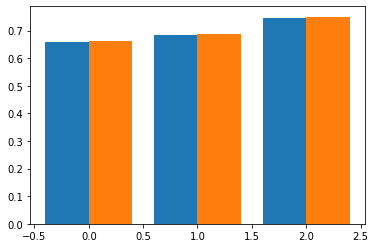

In [ ]:
bar_width = 0.4
bar1 = plt.bar(np.arange(3) - bar_width/2, np.array(accuracy_comparison.loc[:,['simple']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(3) + bar_width/2, np.array(accuracy_comparison.loc[:,['simple + time']]).flatten(), bar_width)

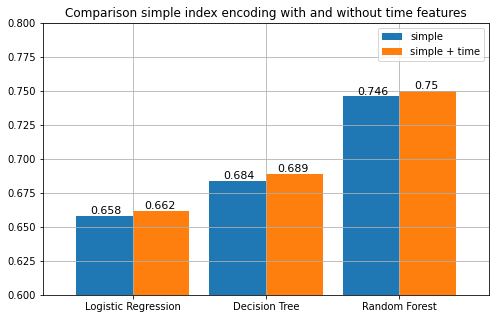

In [ ]:
accuracy_comparison.plot.bar(figsize = (8, 5), rot = 0, grid=True, ylim = (0.6, 0.8), width = .85)
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=11, rotation = 0)
_ = plt.title('Comparison simple index encoding with and without time features') 

#### Compare all results

In [ ]:
accuracy_comparison = pd.DataFrame(np.array([[0.658, 0.662, 0.728, 0.715, 0.732],
                                    [0.684, 0.689, 0.794, 0.816, 0.772],
                                    [0.746, 0.75, 0.816, 0.816, 0.82]]), 
                                    index = ['Logistic Regression', 'Decision Tree', 'Random Forest'] , columns=['simple', 'simple + time', 'simple + trace attributes', 'simple + trace attributes + time', 'simple + trace attributes + time + event']).T
print('Test accuracy comparisons')
accuracy_comparison

Test accuracy comparisons


,Logistic Regression,Decision Tree,Random Forest
simple,0.658,0.684,0.746
simple + time,0.662,0.689,0.750
simple + trace attributes,0.728,0.794,0.816
simple + trace attributes + time,0.715,0.816,0.816
simple + trace attributes + time + event,0.732,0.772,0.820


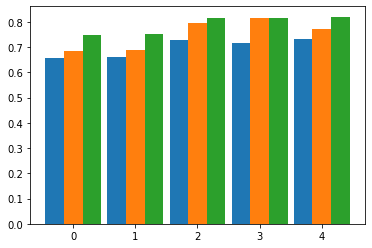

In [ ]:
bar_width = 0.3
bar1 = plt.bar(np.arange(5) - bar_width, np.array(accuracy_comparison.loc[:,['Logistic Regression']]).flatten(), bar_width)
bar2 = plt.bar(np.arange(5), np.array(accuracy_comparison.loc[:,['Decision Tree']]).flatten(), bar_width)
bar3 = plt.bar(np.arange(5) + bar_width, np.array(accuracy_comparison.loc[:,['Random Forest']]).flatten(), bar_width)

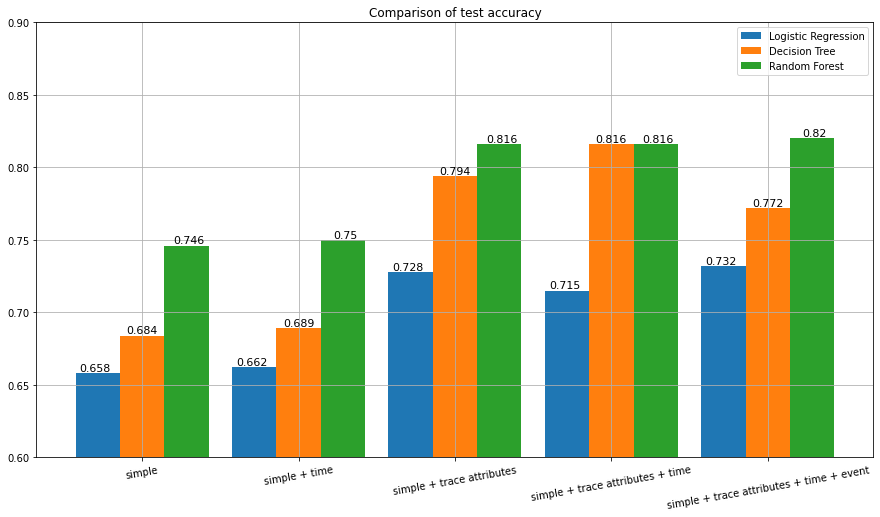

In [ ]:
accuracy_comparison.plot.bar(figsize = (15, 8), rot = 10, grid=True, ylim = (0.6, 0.9), width = .85)
for rect in bar1 + bar2 + bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height,3), ha='center', va='bottom', fontsize=11, rotation = 0)
_ = plt.title('Comparison of test accuracy') 